# Non-linear neural network factor model in Finance

## Overview

The notebook contains the various non-linear neural network factor models. There are more versions of the neural network that has been applied in the investigation than what is shown in the delivered article. Since only the most promising configurations are in the article. 

The notebook has the following struture: 

1. Support classes
2. The 9 factor base case for the neural network _base_ factor model and the neural network _extended_ factor model
3. The autoencoder
4. The "AE 20 factor" base case similar to the "9 factor" case.

The _base_ and _extended_ neural network models takes a dictornary containing the dataloader for the training data set, the validation data set and the test data set.

Each dataloader applies a certain database that is a specific structure of data applied for the model.

Each neural network factor model can be called with design parameters for the neural network for training af statistics. Due to computational time only the most promising neural network factor models described in the article are function calls provided for, but parameters can just be changed in these calls to run other configurations.

Function calls for the autoencoder is provided for the intrinsic dimension 20 i.e. 20 factor case for the linear AE and for a non-linear AE. The part of the code that generates new $(\alpha , \beta)$'s by the adaptive model and store these in a file has been commented out, but will work if needed. (The file with $(\alpha , \beta)$'s in the 20 factor case is provided as and input in the "AE 20 factor case).

The notebook needs the module "invlib.py" provided in the folder to read data files and in case the adaptive model is called.


## Base classes for data

In [1]:
# Import of libraries

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import invlib


In [2]:
# Global variables 

factor_levels_fname="factor_levels_data003" # File name on factor levels matching factor weights

factor_weights_fname="factor_weights_data003" # File name of factor weights from adaptive model

prediction_error_fname="pred_error_data003" # File name of prediction errors from adaptive model

return_levels_fname="return_levels_data003" # File name for return levels 

ticker_sector_np_fname="ticker_sector_data003" # File name for numpy stucture with sector id

factor_order_fname="factor_order_data.txt" # File with of factor names in adaptive model

asset_order_fname="asset_order_data.txt" # File with asset names in adaptive model

sector_name_fname="sector_id.txt"  # File with sector names

no_beta_factors=9  # Number of beta factors

no_assets=638 # Number of assets

no_dataset=4134  # Number of data

batch_size = 1000  # Batch size

training_set_no_data=1378 # Number of data in training set

validation_set_no_data=1378 # Number of data in validation set

test_set_no_data=1378 # Number of data in test set



In [3]:
# Database applied to read datafiles and store results in numpy structure

class database():
    """
    Class that loads data
    """
    def __init__(self,factor_levels_fn,factor_weights_fn,prediction_error_fn,return_levels_fn,ticker_sector_np_fn):
        """ Loads data into numpy arrays
        """

        loader=invlib.asset_data()

        tmp_factor_weights=loader.load_return_data_from_file(factor_weights_fn)
        self.factor_weights_np=np.reshape(tmp_factor_weights,(no_dataset,no_beta_factors+1,no_assets))
        self.return_data_np=loader.load_return_data_from_file(return_levels_fn)
        self.error_affine_model_np=loader.load_return_data_from_file(prediction_error_fn)
        self.factor_level_np=loader.load_return_data_from_file(factor_levels_fname)
        self.sector_id_np=loader.load_return_data_from_file(ticker_sector_np_fn)

data=database(factor_levels_fname,factor_weights_fname,prediction_error_fname,return_levels_fname,ticker_sector_np_fname)


## Support classes for neural networks

In [4]:
# Convert a binary vector to digit (applied for sector codes)

def bin2int(bvec):

    sum=0
    vv=1

    for ii in range(len(bvec)):
        sum+=bvec[ii]*vv
        vv*=2

    return sum

In [5]:
# General function that trains the neural network in one epoch by iterating over all the batches

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        # print shape
        # print(f'x.sh{X.shape} y.sh{y.shape} pred.sh{pred.shape}')
        
#        loss = loss_fn(pred.flatten(), y)
        loss = loss_fn(pred.flatten(), y.flatten())

        # Compute return variance

        output_var=(y**2).sum()/torch.numel(y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

#        if batch % 100 == 0:
#            loss, current = loss.item(), (batch + 1) * len(X)
#            print(f'Training R^2={1-loss/output_var}')


In [6]:
# This function calculates loss and R² for a dataset given a model

def c_stat(dataloader, model, loss_fn,label_=None,pr_stat=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    t_loss,output_var, nn  = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            t_loss += loss_fn(pred.flatten(), y.flatten()).item()          
            output_var+=(y**2).sum()/torch.numel(y)
            nn+=1

    R2=1-t_loss/output_var
    
    if pr_stat:
        print(f"{label_} R^2={R2}\n")

    
    return R2, t_loss/nn


In [7]:
# This function runs the training of the neural network and calculate statistics


def run_model(model,optimizer,loss_fn,epochs,dataloader,fn=None,label=None):
    """
    Train model and test against validation and test data and print results
    
    model :  nn.module
        neural network
    optimizer : torch.optim
        applied for training of model
    loss_fn : torch.nn
        loss function
    epochs : int>0
        number of iterations in optimizer
    dataloader : dictionary 
        dictionary containing dataloaders for "train","validation","test"
    """

    # Initialisation
    
    train_iter=[]
    train_loss=[]
    train_R2=[]

    valid_iter=[]
    valid_loss=[]
    valid_R2=[]

    test_iter=[]
    test_loss=[]
    test_R2=[]

    max_train_R2=0
    max_valid_R2=0
    max_test_R2=0
    max_iter=-1
    
    

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(dataloader['train'], model, loss_fn, optimizer)

        R2_train,loss_train=c_stat(dataloader['train'], model, loss_fn,label_="training")
        R2_validation,loss_validation=c_stat(dataloader['validation'], model, loss_fn,label_="validation")
        R2_test,loss_test=c_stat(dataloader['test'], model, loss_fn,label_="test")

        #    if R2_train>=0 and R2_validation>=0 and R2_test>=0:
        if True: 
        
            train_iter.append(t)
            train_loss.append(loss_train)
            train_R2.append(R2_train.numpy(force=True))
    
            valid_iter.append(t)
            valid_loss.append(loss_validation)
            valid_R2.append(R2_validation.numpy(force=True))

            test_iter.append(t)
            test_loss.append(loss_test)
            test_R2.append(R2_test.numpy(force=True))

        # Search for pareto optimal solution

        if R2_train.numpy(force=True)>=max_train_R2 and R2_validation.numpy(force=True)>=max_valid_R2 and R2_test.numpy(force=True)>=max_test_R2:
            max_train_R2=R2_train.numpy(force=True)
            max_valid_R2=R2_validation.numpy(force=True)
            max_test_R2=R2_test.numpy(force=True)
            max_iter=t

    # Print results

    print(f'Pareto optimal solution: iter*: {max_iter:.0f} training_R2*: {max_train_R2:.6f} validation_R2*: {max_valid_R2:.6f} test_R2*: {max_test_R2:.6f}')

    # Plot results

    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
#    fig = plt.figure(figsize=(6,8)) # temp
#    plt.subplot(2,1,1) # temporary
    plt.plot(train_iter, train_loss, label='train_loss')
    plt.plot(valid_iter, valid_loss, label='valid_loss')
    plt.plot(test_iter, test_loss, label='test_loss')
    plt.legend()

    plt.subplot(1, 2, 2)
#    plt.subplot(2, 1, 2) # temp
    plt.plot(train_iter, train_R2, label='train_R2')
    plt.plot(valid_iter, valid_R2, label='valid_R2')
    plt.plot(test_iter, test_R2, label='test_R2')
    plt.legend()

    
    # Save results to files
    
    if fn!=None: 
        fig.savefig(fn+'.png',format='png')
        

        f=open(fn+'.txt','w')

        if label!=None:
            f.write(label)

        f.write(f'\n Pareto optimal solution:\n iter*: {max_iter:.0f} training_R2*: {max_train_R2:.6f} validation_R2*: {max_valid_R2:.6f} test_R2*: {max_test_R2:.6f}\n')
        f.write(f'#iteration training_loss validation_loss test_loss training_R2 validation_R2 test_R2\n')
        for ii in range(len(train_iter)):
            f.write(f'{train_iter[ii]:.0f} {train_loss[ii]:.6f} {valid_loss[ii]:.6f} {test_loss[ii]:.6f} {train_R2[ii]:.6f} {valid_R2[ii]:.6f} {test_R2[ii]:.6f}\n')
        f.close()


    plt.show()    


In [8]:
# Calculate sector statisics

def c_sec_stat(model,loss_fn,mdata,sec_id_fn,from_id,to_id,fn=None,label=None):

    sec_id_lst=invlib.rd_ticker_file(sec_id_fn)
    no_sec=len(sec_id_lst)
    R2_lst=[]
    sec_mdata,sec_nitem=mdata.filter_data(sec_id_lst,from_id,to_id)
    tot_nitem=np.array(sec_nitem).sum()
    sum_loss2=0
    sum_var=0

    for sec_id in range(no_sec):
        dloader=DataLoader(sec_mdata[sec_id],batch_size=batch_size,shuffle=True)
        
        size = len(dloader.dataset)
        num_batches = len(dloader)
        model.eval()
        t_loss, output_var  = 0, 0
        with torch.no_grad():
            for X, y in dloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                t_loss += loss_fn(pred.flatten(), y).item()
                output_var+=(y**2).sum()/torch.numel(y)

        sum_loss2+=t_loss
        sum_var+=output_var

        R2=1.0-t_loss/output_var
        R2_lst.append(float(R2.float()))

    R2=1.0-sum_loss2/sum_var
    R2_lst.append(float(R2.float()))

    label_lst=[]
    for ii in range(no_sec):
        str_=sec_id_lst[ii]+f' ({(sec_nitem[ii]/tot_nitem*100):.1f}%)'
        label_lst.append(str_)
        
    str_=f'Total (100.0%)'
    label_lst.append(str_)        

    # plot diagramme

    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(8, 4))
        sns.barplot(x=label_lst, y=R2_lst)
        plt.xticks(rotation=90)
        plt.title("R2 for "+label)
        plt.ylabel("R2")

        if fn!=None: 
            plt.savefig(fn+'_R2'+label+'.png',format='png',bbox_inches='tight')
        
        plt.show()

    # Save data to file

    if fn!=None: 
        f=open(fn+'.txt','a')
        f.write('\nR2 on sectors '+label+'\n')
        for ii in range(len(sec_id_lst)):
            f.write(f'{sec_id_lst[ii]} {R2_lst[ii]:.2f}\n')
        f.close()

    # return data

    return sec_id_lst,R2_lst
    
        

### Neural network block functions

In [9]:
def gen_FFN_block(feature_vec_dim,output_vec_dim,no_hidden_layers,no_nodes_in_layer,P_dropout,activation=None):
    """ Generates a FFN in a list """
    
    if activation==None:

        activation=nn.ReLU()
            
    else:
            
        activation=activation
            
    FFN=[]
        
    FFN.append(nn.Linear(feature_vec_dim, no_nodes_in_layer))
    FFN.append(nn.Dropout(p=P_dropout))
    FFN.append(nn.BatchNorm1d(no_nodes_in_layer))
    FFN.append(activation)        
        
    for ii in range(no_hidden_layers):
        FFN.append(nn.Linear(no_nodes_in_layer, no_nodes_in_layer))
        FFN.append(nn.Dropout(p=P_dropout))
        FFN.append(nn.BatchNorm1d(no_nodes_in_layer))    
        FFN.append(activation)

            
    FFN.append(nn.Linear(no_nodes_in_layer, output_vec_dim))
        
    return FFN


def gen_AE_block(no_nodes_in_layer_lst,P_dropout,activation=None):
    """ Generate Autoencoder """

    if activation==None:

        activation=nn.ReLU()
            
    else:
            
        activation=activation
            
    AE=[]

    no_layers=len(no_nodes_in_layer_lst)
        
    for ii in range(no_layers-2):
        AE.append(nn.Linear(no_nodes_in_layer_lst[ii], no_nodes_in_layer_lst[ii+1]))
        AE.append(nn.Dropout(p=P_dropout))
        AE.append(nn.BatchNorm1d(no_nodes_in_layer_lst[ii+1]))   
        if activation!=None: 
            AE.append(activation)

            
    AE.append(nn.Linear(no_nodes_in_layer_lst[no_layers-2],no_nodes_in_layer_lst[no_layers-1]))
        
    return AE


def gen_Conv1D_block(channel_in,no_conv_layers,channel_out_lst,kernel_size_lst,seq_lgth): 
    """ Generate a convolutional block """
            
    CNN=[]


    C_in=channel_in
    C_L_in=seq_lgth


    for ii in range(no_conv_layers):

        CNN.append(nn.Conv1d(in_channels=C_in,out_channels=channel_out_lst[ii],\
                                 kernel_size=kernel_size_lst[ii]))

        CNN.append(nn.MaxPool1d(kernel_size=kernel_size_lst[ii]))


            
        C_out=channel_out_lst[ii]
        stride_M=kernel_size_lst[ii]

        C_L_out=C_L_in-(kernel_size_lst[ii]-1)-1+1
        M_L_in=C_L_out
        M_L_out=int((M_L_in-(kernel_size_lst[ii]-1)-1)/stride_M+1)

        C_L_in=M_L_out
        C_in=C_out


    return CNN,C_out,M_L_out
        
        

# Sector statistics for input data (adaptive affine model)

Adaptive affine model training R^2=42.14%
Adaptive affine model validation R^2=25.93%
Adaptive affine model test R^2=38.06%


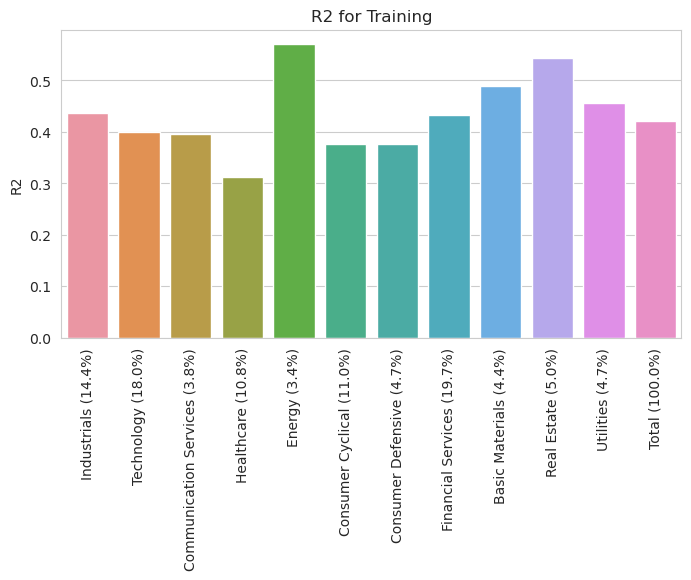

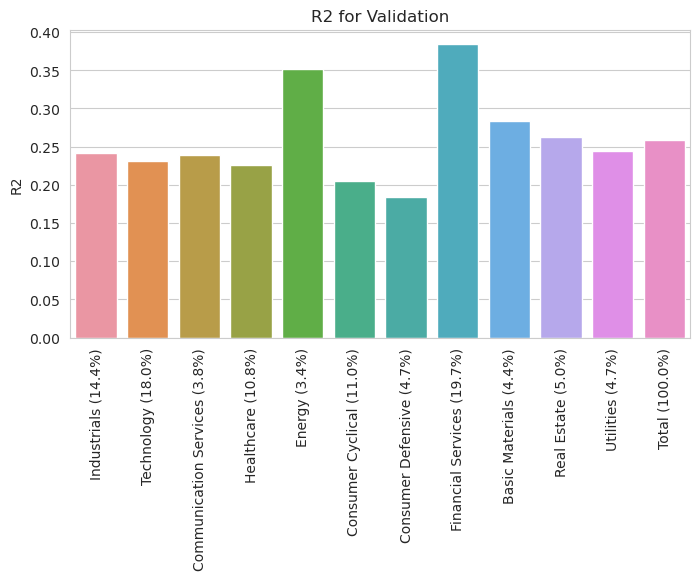

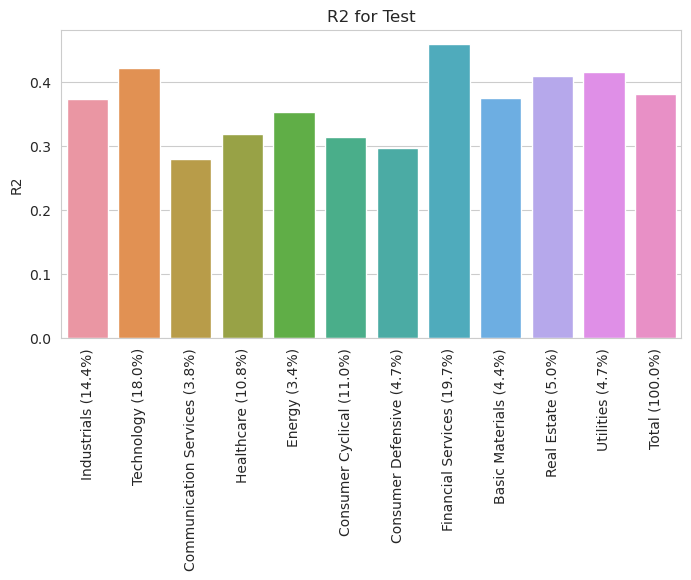

(['Industrials',
  'Technology',
  'Communication Services',
  'Healthcare',
  'Energy',
  'Consumer Cyclical',
  'Consumer Defensive',
  'Financial Services',
  'Basic Materials',
  'Real Estate',
  'Utilities'],
 [0.3737848439134409,
  0.4221719295253926,
  0.27942102994450224,
  0.3176304322258363,
  0.35241403801154225,
  0.31357172224187313,
  0.2963384665520763,
  0.45882536494277915,
  0.37533088320161334,
  0.4085330763571795,
  0.4145811268878117,
  0.38056381014432983])

In [10]:
# Calculate R^2 for adaptive affine model

def c_stat_adaptive_model(data,sec_id_fn,from_id,to_id,fn=None,label=None):

        # Initialise

        sec_id_lst=invlib.rd_ticker_file(sec_id_fn)
        sec_id_vec=data.sector_id_np
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=(to_id-from_id+1)*no_assets
        feature_dim_t=(2*no_beta_factors+1)   
            
        # Create lists of data
        
        i_data_lst=[]
        e_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(np.array([0]))
            e_data_lst.append(np.array([0]))

        # Create index lists

        i_index_lst=[]
        o_index_lst=[]

        for ii in range(no_sec):
            i_index_lst.append([])
            o_index_lst.append([])
        
        # Assign data to sector lists

        for jj in range(no_assets):
            si=int(bin2int(sec_id_vec[jj])) # Sector id binary
            i_index_lst[si].append((no_beta_factors+jj)) 
            o_index_lst[si].append(jj)

        tot_var=0
        tot_error2=0

        # Calculate R2 for sectors

        sec_nitem=[]
        R2_lst=[]
        tot_nitem=0


        for ii in range(no_sec):
            error2=(data.error_affine_model_np[from_id:to_id,o_index_lst[ii]]**2).sum()
            var_=(data.return_data_np[from_id:to_id,i_index_lst[ii]]**2).sum()
            tot_var+=var_
            tot_error2+=error2
            R2_lst.append((1-error2/var_))
            nitem=len(i_index_lst[ii])
            sec_nitem.append(nitem)
            tot_nitem+=nitem

        R2_lst.append((1-tot_error2/tot_var))

        # Create label list 
            
        label_lst=[]
        for ii in range(no_sec):
            str_=sec_id_lst[ii]+f' ({(sec_nitem[ii]/tot_nitem*100):.1f}%)'
            label_lst.append(str_)
        
        str_=f'Total (100.0%)'
        label_lst.append(str_)        

        # plot diagramme

        with sns.axes_style('whitegrid'):
            plt.figure(figsize=(8, 4))
            sns.barplot(x=label_lst, y=R2_lst)
            plt.xticks(rotation=90)
            plt.title("R2 for "+label)
            plt.ylabel("R2")

            if fn!=None: 
                plt.savefig(fn+'_R2'+label+'.png',format='png',bbox_inches='tight')
        
            plt.show()

        # Save data to file

        if fn!=None: 
            f=open(fn+'.txt','a')
            f.write('\nR2 on sectors '+label+'\n')
            for ii in range(len(sec_id_lst)):
                f.write(f'{sec_id_lst[ii]} {R2_lst[ii]:.2f}\n')
            f.close()

        # return data

        return sec_id_lst,R2_lst




i1=training_set_no_data
i2=i1+validation_set_no_data
i3=i2+test_set_no_data

R2_amodel_training=1-(data.error_affine_model_np[:i1]**2).sum()/(data.return_data_np[:i1,no_beta_factors:]**2).sum()
R2_amodel_validation=1-(data.error_affine_model_np[i1:i2]**2).sum()/(data.return_data_np[i1:i2,no_beta_factors:]**2).sum()
R2_amodel_test=1-(data.error_affine_model_np[i2:]**2).sum()/(data.return_data_np[i2:,no_beta_factors:]**2).sum()

print(f'Adaptive affine model training R^2={(R2_amodel_training*100):.2f}%')
print(f'Adaptive affine model validation R^2={(R2_amodel_validation*100):.2f}%')
print(f'Adaptive affine model test R^2={(R2_amodel_test*100):.2f}%')

# Calculate on sector level

adaptive_data_fn='adaptive'

c_stat_adaptive_model(data,sector_name_fname,0,i1,fn=adaptive_data_fn+'_training',label='Training')
c_stat_adaptive_model(data,sector_name_fname,i1,i2,fn=adaptive_data_fn+'_validation',label='Validation')
c_stat_adaptive_model(data,sector_name_fname,i2,i3,fn=adaptive_data_fn+'_test',label='Test')

# _Base_ neural network factor model

This section contains the code for the _base_ model. The related database applied in the dataloader is denoted market_data_base2 (for model B2). 

##  _Base_ model: $(\alpha ,(\beta \times \Delta F))$ as input

In [11]:
#Database for basic neural network model B2


class data_base(Dataset):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,input_data=None,output_data=None):
        """ 
        Loads data and store en numpy array
        """

        self.input_data_t=input_data
        self.output_data_t=output_data

                

    def __len__(self):
        """ Returns number of data """
        return len(self.output_data_t)


    def __getitem__(self,idx):
        """ Return data sample with id idx """

        return self.input_data_t[idx],self.output_data_t[idx]

class market_data_base2(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        no_data=(to_id-from_id+1)*no_assets

        dim_feature_vec=(no_beta_factors+1)  # (alhpa,beta)-vector and factor change
        
        t_vec=np.zeros(no_beta_factors,dtype=np.float32)

        self.input_data_np=np.zeros((no_data,dim_feature_vec),dtype=np.float32)

        self.output_data_np=np.zeros(no_data,dtype=np.float32)

        p_input_data=0

        for ii in range(from_id,to_id+1):
            for jj in range(no_assets):
                t_vec=data.factor_weights_np[ii,1:,jj]*data.return_data_np[ii,:no_beta_factors]
                vv=np.array([data.factor_weights_np[ii,0,jj]])
                self.input_data_np[p_input_data,:]=np.concatenate((vv,t_vec))
                self.output_data_np[p_input_data]=data.return_data_np[ii,no_beta_factors+jj]
                p_input_data+=1

        self.data=data

        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np) 

        super().__init__(input_data_t,output_data_t)
        
    def filter_data(self,sec_id_lst,from_id,to_id):


        # Initialise
        
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=(to_id-from_id+1)
        dim_feature_vec=(2*no_beta_factors+1)
        sec_id_vec=np.zeros(no_assets,dtype=int)     
        is_initialised=np.zeros(no_sec,dtype=bool)

        # Map company id to sector id       

        for ii in range(no_assets):
            si=int(bin2int(data.sector_id_np[ii]))
            sec_id_vec[ii]=si
            
        # Create lists of data
        
        i_data_lst=[]
        o_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(np.array([0.0]))
            o_data_lst.append(np.array([0.0]))

        
        for jj in range(no_assets):
            si=sec_id_vec[jj]
            if is_initialised[si]:
                t_vec=data.factor_weights_np[from_id:to_id+1,1:,jj]*data.return_data_np[from_id:to_id+1,:no_beta_factors]              
                vv=data.factor_weights_np[from_id:to_id+1,0,jj].reshape(to_id-from_id+1,1)
                mm=np.concatenate((vv,t_vec),axis=1,dtype=np.float32)
                i_data_lst[si]=np.concatenate((i_data_lst[si],mm),axis=0)
                o_data_lst[si]=np.concatenate((o_data_lst[si],data.return_data_np[from_id:to_id+1,no_beta_factors+jj]),axis=0,dtype=np.float32)
            else:
                t_vec=data.factor_weights_np[from_id:to_id+1,1:,jj]*data.return_data_np[from_id:to_id+1,:no_beta_factors]                              
                vv=data.factor_weights_np[from_id:to_id+1,0,jj].reshape(to_id-from_id+1,1)
                i_data_lst[si]=np.concatenate((vv,t_vec),axis=1,dtype=np.float32)
                o_data_lst[si]=data.return_data_np[from_id:to_id+1,no_beta_factors+jj]
                is_initialised[si]=True 
                
        # Count number of data points

        for ii in range(no_sec):
            dim_sec_data[ii]=o_data_lst[ii].shape[0]                

        # Create data base list                
        
        datab_lst=[]
        
        for ii in range(no_sec):
            datab_lst.append(data_base(torch.from_numpy(i_data_lst[ii]),torch.from_numpy(o_data_lst[ii])))
            
        # return data base list and list with number of data points            

        return datab_lst,dim_sec_data
         


        


# Create data loaders.

training_data_b2=market_data_base2(data,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_b2=market_data_base2(data,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_b2=market_data_base2(data,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_b2 = DataLoader(training_data_b2, batch_size=batch_size,shuffle=True)
validation_dataloader_b2=DataLoader(validation_data_b2, batch_size=batch_size,shuffle=True)
test_dataloader_b2 = DataLoader(test_data_b2, batch_size=batch_size,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_b2.__len__()}')
print(f'number of validation batches {validation_dataloader_b2.__len__()}')
print(f'number of test batches {test_dataloader_b2.__len__()}')

# train_features, train_output = next(iter(train_dataloader_base))
# validation_features, validation_output = next(iter(validation_dataloader_base))
# test_features,test_output=next(iter(test_dataloader_base))


number of training batches 880
number of validation batches 880
number of test batches 880


### _Base_ model

In [12]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
#    if torch.backends.mps.is_available()
#    else "cpu"
)
print(f"Using {device} device")


class NN_B(nn.Module):
    def __init__(self,feature_vec_dim,output_vec_dim,num_layers,num_hidden_nodes,P_dropout,activation=None):

        super().__init__()

        if activation==None:

            self.activation=nn.ReLU()
            
        else:
            
            self.activation=activation
            
        FFN=[]
        
        FFN.append(nn.Linear(feature_vec_dim, num_hidden_nodes))
        FFN.append(nn.Dropout(p=P_dropout))
        FFN.append(nn.BatchNorm1d(num_hidden_nodes))
        FFN.append(self.activation)        
        
        for ii in range(num_layers):
            FFN.append(nn.Linear(num_hidden_nodes, num_hidden_nodes))
            FFN.append(nn.Dropout(p=P_dropout))
            FFN.append(nn.BatchNorm1d(num_hidden_nodes))    
            FFN.append(self.activation)

            
        FFN.append(nn.Linear(num_hidden_nodes, output_vec_dim))
              
        
        self.FFN=nn.ModuleList(FFN)
            

    def forward(self, x):

        for ff in self.FFN:
            x=ff(x)
            
        return_vec=x 
                
        return return_vec



Using cuda device


### _Base_ model interface 

In [13]:
# Model B2

def run_b2(feature_vec_dim_b2,output_vec_dim,num_layers,num_hidden_nodes,P_dropout,lr,epochs,fname,model_info_b2,data_loader_b2,dataset):


    model_b2 = NN_B(feature_vec_dim=feature_vec_dim_b2,output_vec_dim=output_vec_dim,num_layers=num_layers,\
                num_hidden_nodes=num_hidden_nodes,P_dropout=P_dropout).to(device)
    print(model_b2)

    loss_fn_b2 = nn.MSELoss()
    optimizer_b2 = torch.optim.Adam(model_b2.parameters(), lr=lr)

    # Run base factor model

    run_model(model_b2,optimizer_b2,loss_fn_b2,epochs,dataloader_b2,fname,label=model_info_b2)

    # Calculate R2 on sectors

    from_id,to_id=0,training_set_no_data-1
    c_sec_stat(model_b2,loss_fn_b2,dataset['train'],sector_name_fname,from_id,to_id,fname,'training_data')

    from_id,to_id=training_set_no_data,training_set_no_data+validation_set_no_data-1
    c_sec_stat(model_b2,loss_fn_b2,dataset['validation'],sector_name_fname,from_id,to_id,fname,'validation_data')

    from_id,to_id=training_set_no_data+validation_set_no_data,training_set_no_data+validation_set_no_data+test_set_no_data-1
    c_sec_stat(model_b2,loss_fn_b2,dataset['test'],sector_name_fname,from_id,to_id,fname,'test_data')

Run the _base_ model for number of factors is 9:

NN_B(
  (activation): ReLU()
  (FFN): ModuleList(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=50, out_features=50, bias=True)
    (17): Dropout(p=0.2, inplace=False)
    (18): BatchNorm1d(50, e

training R^2=0.38741135597229004

validation R^2=0.14592939615249634

test R^2=0.3442467451095581

Epoch 51
-------------------------------
training R^2=0.39894407987594604

validation R^2=0.11781513690948486

test R^2=0.34867507219314575

Epoch 52
-------------------------------
training R^2=0.4242289066314697

validation R^2=0.19369065761566162

test R^2=0.38828736543655396

Epoch 53
-------------------------------
training R^2=0.44101637601852417

validation R^2=0.1904098391532898

test R^2=0.3959957957267761

Epoch 54
-------------------------------
training R^2=0.3964769244194031

validation R^2=0.10259449481964111

test R^2=0.34090542793273926

Epoch 55
-------------------------------
training R^2=0.3997091054916382

validation R^2=0.15230154991149902

test R^2=0.3508864641189575

Epoch 56
-------------------------------
training R^2=0.3814648389816284

validation R^2=0.05978691577911377

test R^2=0.32893866300582886

Epoch 57
-------------------------------
training R^2=0.406299

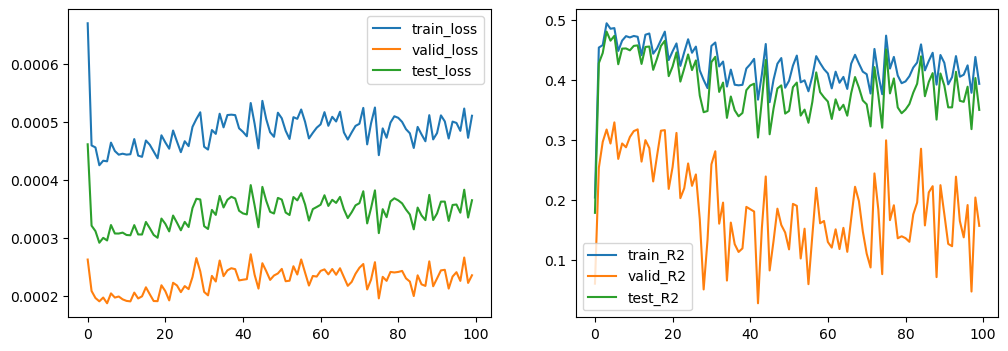

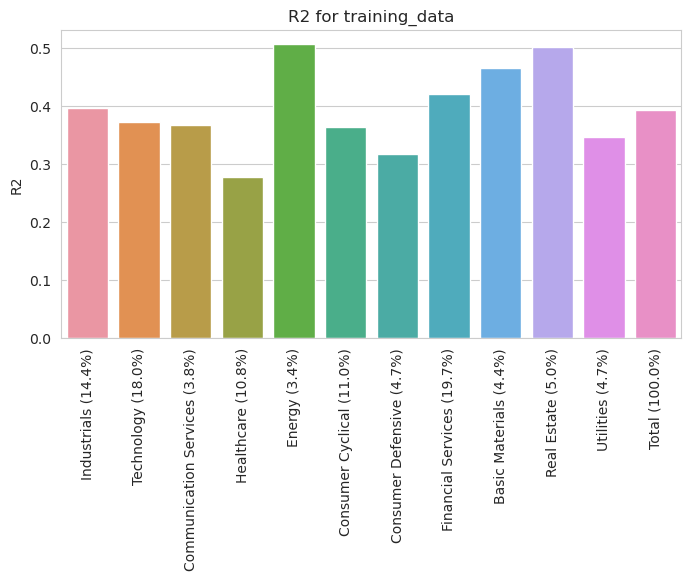

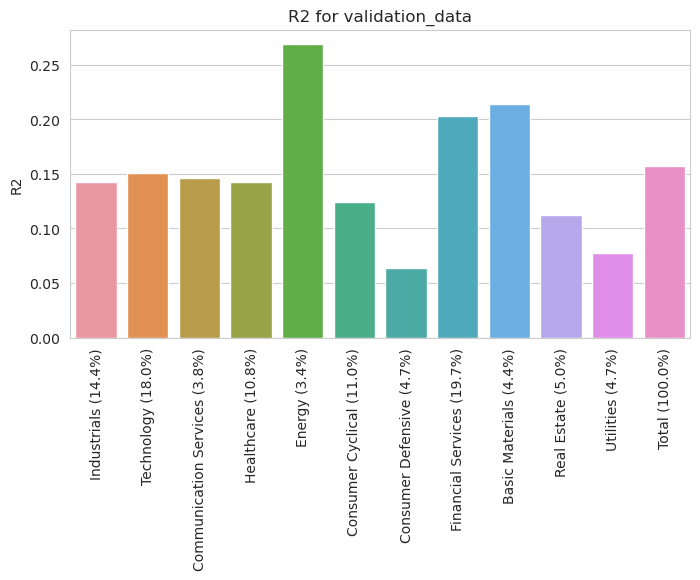

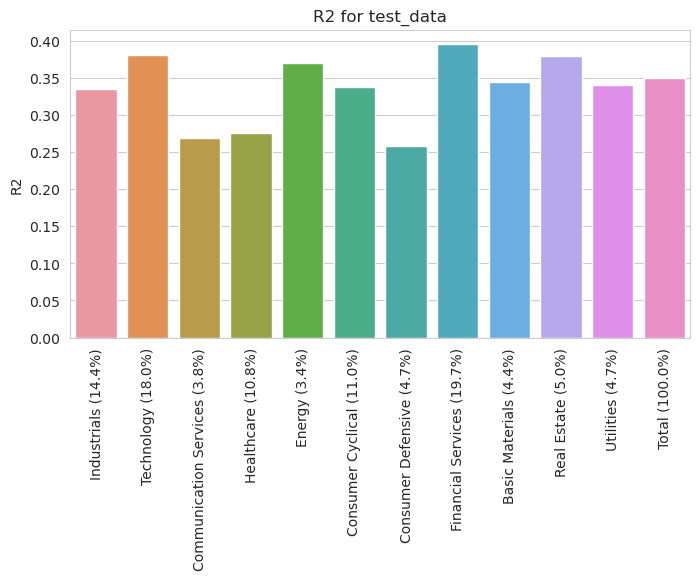

In [14]:
# ------- Run base model

dataset={
        'train' : training_data_b2,
        'validation' : validation_data_b2,
        'test' : test_data_b2 
    }

dataloader_b2={
        'train' : train_dataloader_b2,
        'validation' : validation_dataloader_b2,
        'test' : test_dataloader_b2 
    }

model_info="Model: base model"


feature_vec_dim_b2=no_beta_factors+1
output_vec_dim=1
num_layers=5
num_hidden_nodes=50
P_dropout=0.2
lr=1e-3
epochs=100
fname='run_base'

run_b2(feature_vec_dim_b2,output_vec_dim,num_layers,num_hidden_nodes,P_dropout,lr,epochs,fname,model_info,dataloader_b2,dataset)

# _Extended_ neural network factor model

## Datasets

In the following code the different data sets for the _extended_ model are generated.

### Dataset: market_data_adv (input $(F,\Delta F,\alpha,\beta ,\mbox{sector id},R)$)

In [15]:
class market_data_adv(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,T_backward=1,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """
        
        self.T_backward=T_backward


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        if from_id<T_backward:
            no_data=(to_id-T_backward+2)*no_assets
            start_id=T_backward-1
        else:        
            no_data=(to_id-from_id+1)*no_assets
            start_id=from_id

        self.dim_feature_vec_t=max(2*no_beta_factors+5,3*no_beta_factors+2) # (alhpa,beta)-vector and factor change and sector id

        self.dim_feature_vec_0=2*no_beta_factors+1
        
        self.input_data_np=np.zeros((no_data,T_backward,self.dim_feature_vec_t),dtype=np.float32)

        self.output_data_np=np.zeros(no_data,dtype=np.float32)

        p_input_data=0

        self.data=data

        for ii in range(start_id,to_id+1):
            for jj in range(no_assets):
                for tt in range(T_backward):
                    if tt==0: 
                        self.input_data_np[p_input_data,T_backward-1-tt,:2*no_beta_factors+5]=\
                                                    np.concatenate((data.factor_weights_np[ii,:,jj],\
                                                    data.return_data_np[ii,:no_beta_factors],data.sector_id_np[jj,:]))
                    else:        
                        self.input_data_np[p_input_data,T_backward-1-tt,:3*no_beta_factors+2]=\
                                                    np.concatenate((data.factor_weights_np[ii-tt,:,jj],\
                                                    data.return_data_np[ii-tt,:no_beta_factors],\
                                                    np.array([data.return_data_np[ii-tt,no_beta_factors+jj]]),\
                                                    data.factor_level_np[ii-tt,:]))   
                    
                self.output_data_np[p_input_data]=data.return_data_np[ii,no_beta_factors+jj]
                p_input_data+=1



        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np)     

        super().__init__(input_data_t,output_data_t)


    def filter_data(self,sec_id_lst,from_id,to_id):


        # Initialise
        
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=self.input_data_t.shape[0]
        feature_dim_t=(2*no_beta_factors+1)   


            
        # Create lists of data
        
        i_data_lst=[]
        o_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(torch.zeros(1))
            o_data_lst.append(torch.zeros(1))

        # Create index lists

        index_lst=[]

        for ii in range(no_sec):
            index_lst.append([])
        
        # Assign data to sector lists

        for ii in range(n_data_item):
            si=int(bin2int(self.input_data_t[ii,self.T_backward-1,self.dim_feature_vec_0:(self.dim_feature_vec_0+4)])) # Sector id binary
            index_lst[si].append(ii)

        # Assign data to i_data_lst and o_data_lst

        for si in range(no_sec):
            i_data_lst[si]=self.input_data_t[index_lst[si]]
            o_data_lst[si]=self.output_data_t[index_lst[si]]                                  
    
                
        # Count number of data points

        for ii in range(no_sec):
            dim_sec_data[ii]=o_data_lst[ii].shape[0]                

        # Create data base list                
        
        datab_lst=[]
        
        for ii in range(no_sec):
            datab_lst.append(data_base(i_data_lst[ii],o_data_lst[ii]))
            
        # return data base list and list with number of data points            

        return datab_lst,dim_sec_data         


# Parameters

T_bkwd=10 # Number of trading days there is look back >=2

batch_size_adv=1000 # Batch size

# Create data loaders.

training_data_adv=market_data_adv(data,T_bkwd,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_adv=market_data_adv(data,T_bkwd,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_adv=market_data_adv(data,T_bkwd,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_adv = DataLoader(training_data_adv, batch_size=batch_size_adv,shuffle=True)
validation_dataloader_adv=DataLoader(validation_data_adv, batch_size=batch_size_adv,shuffle=True)
test_dataloader_adv = DataLoader(test_data_adv, batch_size=batch_size_adv,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_adv.__len__()}')
print(f'number of validation batches {validation_dataloader_adv.__len__()}')
print(f'number of test batches {test_dataloader_adv.__len__()}')

# train_features, train_output = next(iter(train_dataloader_adv))
# validation_features, validation_output = next(iter(validation_dataloader_adv))
# test_features,test_output=next(iter(test_dataloader_adv))


number of training batches 874
number of validation batches 880
number of test batches 880


### Data set E2: model input $( \Delta F_{proj}, F,R)$

In [16]:
class market_data_E2(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,T_backward=1,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """
        
        self.T_backward=T_backward


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        if from_id<T_backward:
            no_data=(to_id-T_backward+2)*no_assets
            start_id=T_backward-1
        else:        
            no_data=(to_id-from_id+1)*no_assets
            start_id=from_id

        self.dim_feature_vec_t=max(no_beta_factors+5,2*no_beta_factors+2) # (alhpa,beta)-vector and factor change and sector id

        self.dim_feature_vec_0=no_beta_factors+1
        
        self.input_data_np=np.zeros((no_data,T_backward,self.dim_feature_vec_t),dtype=np.float32)

        self.output_data_np=np.zeros(no_data,dtype=np.float32)

        p_input_data=0

        self.data=data

        for ii in range(start_id,to_id+1):
            for jj in range(no_assets):
                for tt in range(T_backward):
                    if tt==0: 
                        t_vec=data.factor_weights_np[ii,1:,jj]*data.return_data_np[ii,:no_beta_factors]
                        vv=np.array([data.factor_weights_np[ii,0,jj]])
                        self.input_data_np[p_input_data,T_backward-1-tt,:no_beta_factors+5]=\
                                                    np.concatenate((vv,t_vec,data.sector_id_np[jj,:]))
                    else:  
                        t_vec=data.factor_weights_np[ii-tt,1:,jj]*data.return_data_np[ii-tt,:no_beta_factors]
                        vv=np.array([data.factor_weights_np[ii-tt,0,jj]])
                        self.input_data_np[p_input_data,T_backward-1-tt,:2*no_beta_factors+2]=\
                                                    np.concatenate((vv,t_vec,\
                                                    np.array([data.return_data_np[ii-tt,no_beta_factors+jj]]),\
                                                    data.factor_level_np[ii-tt,:]))   
                    
                self.output_data_np[p_input_data]=data.return_data_np[ii,no_beta_factors+jj]
                p_input_data+=1



        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np)     

        super().__init__(input_data_t,output_data_t)


    def filter_data(self,sec_id_lst,from_id,to_id):


        # Initialise
        
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=self.input_data_t.shape[0]
        feature_dim_t=(2*no_beta_factors+1)   


            
        # Create lists of data
        
        i_data_lst=[]
        o_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(torch.zeros(1))
            o_data_lst.append(torch.zeros(1))

        # Create index lists

        index_lst=[]

        for ii in range(no_sec):
            index_lst.append([])
        
        # Assign data to sector lists

        for ii in range(n_data_item):
            si=int(bin2int(self.input_data_t[ii,self.T_backward-1,self.dim_feature_vec_0:(self.dim_feature_vec_0+4)])) # Sector id binary
            index_lst[si].append(ii)

        # Assign data to i_data_lst and o_data_lst

        for si in range(no_sec):
            i_data_lst[si]=self.input_data_t[index_lst[si]]
            o_data_lst[si]=self.output_data_t[index_lst[si]]                                  
    
                
        # Count number of data points

        for ii in range(no_sec):
            dim_sec_data[ii]=o_data_lst[ii].shape[0]                

        # Create data base list                
        
        datab_lst=[]
        
        for ii in range(no_sec):
            datab_lst.append(data_base(i_data_lst[ii],o_data_lst[ii]))
            
        # return data base list and list with number of data points            

        return datab_lst,dim_sec_data         


# Parameters

T_bkwd=10 # Number of trading days there is look back >=2

batch_size_E2=1000 # Batch size

# Create data loaders.

training_data_E2=market_data_E2(data,T_bkwd,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_E2=market_data_E2(data,T_bkwd,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_E2=market_data_E2(data,T_bkwd,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_E2 = DataLoader(training_data_E2, batch_size=batch_size_E2,shuffle=True)
validation_dataloader_E2=DataLoader(validation_data_E2, batch_size=batch_size_E2,shuffle=True)
test_dataloader_E2 = DataLoader(test_data_E2, batch_size=batch_size_E2,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_E2.__len__()}')
print(f'number of validation batches {validation_dataloader_E2.__len__()}')
print(f'number of test batches {test_dataloader_E2.__len__()}')

# train_features, train_output = next(iter(train_dataloader_E2))
# validation_features, validation_output = next(iter(validation_dataloader_E2))
# test_features,test_output=next(iter(test_dataloader_E2))


number of training batches 874
number of validation batches 880
number of test batches 880


### Data set E3: model input $( \Delta F_{proj}, R)$

In [17]:
class market_data_E3(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,T_backward=1,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """
        
        self.T_backward=T_backward


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        if from_id<T_backward:
            no_data=(to_id-T_backward+2)*no_assets
            start_id=T_backward-1
        else:        
            no_data=(to_id-from_id+1)*no_assets
            start_id=from_id

        self.dim_feature_vec_t=max(no_beta_factors+5,no_beta_factors+2) # (alhpa,beta)-vector and factor change and sector id

        self.dim_feature_vec_0=no_beta_factors+1
        
        self.input_data_np=np.zeros((no_data,T_backward,self.dim_feature_vec_t),dtype=np.float32)

        self.output_data_np=np.zeros(no_data,dtype=np.float32)

        p_input_data=0

        self.data=data

        for ii in range(start_id,to_id+1):
            for jj in range(no_assets):
                for tt in range(T_backward):
                    if tt==0: 
                        t_vec=data.factor_weights_np[ii,1:,jj]*data.return_data_np[ii,:no_beta_factors]
                        vv=np.array([data.factor_weights_np[ii,0,jj]])
                        self.input_data_np[p_input_data,T_backward-1-tt,:no_beta_factors+5]=\
                                                    np.concatenate((vv,t_vec,data.sector_id_np[jj,:]))
                    else:  
                        t_vec=data.factor_weights_np[ii-tt,1:,jj]*data.return_data_np[ii-tt,:no_beta_factors]
                        vv=np.array([data.factor_weights_np[ii-tt,0,jj]])
                        self.input_data_np[p_input_data,T_backward-1-tt,:no_beta_factors+2]=\
                                                    np.concatenate((vv,t_vec,\
                                                    np.array([data.return_data_np[ii-tt,no_beta_factors+jj]])))
  
                    
                self.output_data_np[p_input_data]=data.return_data_np[ii,no_beta_factors+jj]
                p_input_data+=1



        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np)     

        super().__init__(input_data_t,output_data_t)


    def filter_data(self,sec_id_lst,from_id,to_id):


        # Initialise
        
        no_sec=len(sec_id_lst)
        dim_sec_data=np.zeros(no_sec,dtype=int)
        n_data_item=self.input_data_t.shape[0]
        feature_dim_t=(2*no_beta_factors+1)   


            
        # Create lists of data
        
        i_data_lst=[]
        o_data_lst=[]
        
        for ii in range(no_sec):           
            i_data_lst.append(torch.zeros(1))
            o_data_lst.append(torch.zeros(1))

        # Create index lists

        index_lst=[]

        for ii in range(no_sec):
            index_lst.append([])
        
        # Assign data to sector lists

        for ii in range(n_data_item):
            si=int(bin2int(self.input_data_t[ii,self.T_backward-1,self.dim_feature_vec_0:(self.dim_feature_vec_0+4)])) # Sector id binary
            index_lst[si].append(ii)

        # Assign data to i_data_lst and o_data_lst

        for si in range(no_sec):
            i_data_lst[si]=self.input_data_t[index_lst[si]]
            o_data_lst[si]=self.output_data_t[index_lst[si]]                                  
    
                
        # Count number of data points

        for ii in range(no_sec):
            dim_sec_data[ii]=o_data_lst[ii].shape[0]                

        # Create data base list                
        
        datab_lst=[]
        
        for ii in range(no_sec):
            datab_lst.append(data_base(i_data_lst[ii],o_data_lst[ii]))
            
        # return data base list and list with number of data points            

        return datab_lst,dim_sec_data         


# Parameters

T_bkwd=10 # Number of trading days there is look back >=2

batch_size_E3=1000 # Batch size

# Create data loaders.

training_data_E3=market_data_E3(data,T_bkwd,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_E3=market_data_E3(data,T_bkwd,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_E3=market_data_E3(data,T_bkwd,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_E3 = DataLoader(training_data_E3, batch_size=batch_size_E3,shuffle=True)
validation_dataloader_E3=DataLoader(validation_data_E3, batch_size=batch_size_E3,shuffle=True)
test_dataloader_E3 = DataLoader(test_data_E3, batch_size=batch_size_E3,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_E3.__len__()}')
print(f'number of validation batches {validation_dataloader_E3.__len__()}')
print(f'number of test batches {test_dataloader_E3.__len__()}')

# train_features, train_output = next(iter(train_dataloader_E3))
# validation_features, validation_output = next(iter(validation_dataloader_E3))
# test_features,test_output=next(iter(test_dataloader_E3))

number of training batches 874
number of validation batches 880
number of test batches 880


## Model E2

In [18]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
#    if torch.backends.mps.is_available()
#    else "cpu"
)
print(f"Using {device} device")

# Define EM2 model


class NN_EM2(nn.Module):
    def __init__(self,feature_vec_cr_dim,feature_vec_LSTM_dim,feature_vec_FF_dim,output_vec_dim,\
                 no_conv_layers,channel_out,kernel_size,seq_lgth,\
                 cr_aggr_no_layers,cr_aggr_no_nodes,cr_output_vec_dim,\
                 LSTM_hidden_layer_dim,\
                 LSTM_no_layers,LSTM_no_nodes,LSTM_output_vec_dim,
                 num_layers_FF,num_hidden_nodes_FF,P_dropout,activation=None,batch_first=True):

        super().__init__()

        # Set data

        self.feature_vec_cr_dim=feature_vec_cr_dim
        self.feature_vec_LSTM_dim=feature_vec_LSTM_dim
        self.feature_vec_FF_dim=feature_vec_FF_dim
        self.output_vec_dim=output_vec_dim
        self.seq_lgth=seq_lgth

        if activation==None:

            self.activation=nn.ReLU()
            
        else:
            
            self.activation=activation
            
        # ---- Convolution block    
            
        if no_conv_layers>0: 
            
            self.flag_conv_block=True 

            # Convolution layer

            channel_out_lst=[]
            kernel_size_lst=[]
            for ii in range(no_conv_layers):
                channel_out_lst.append(channel_out)
                kernel_size_lst.append(kernel_size)

            conv_lst,C_out,L_out=gen_Conv1D_block(feature_vec_cr_dim,no_conv_layers,channel_out_lst,\
                                               kernel_size_lst,seq_lgth)
            
            self.conv_block=nn.Sequential(*conv_lst)   
            
            # Aggregation layer FFN 
            
            CR_aggr_layer_input_dim=C_out*L_out
            
            CR_aggr_layer=gen_FFN_block(feature_vec_dim=CR_aggr_layer_input_dim,output_vec_dim=cr_output_vec_dim,\
                                        no_hidden_layers=cr_aggr_no_layers,\
                               no_nodes_in_layer=cr_aggr_no_nodes,P_dropout=P_dropout,activation=activation) 
            
            self.conv_aggr_block=nn.Sequential(*CR_aggr_layer)

            dim_cr_out=cr_output_vec_dim
                
 
            
        else:
            
            self.flag_conv_block=False

            dim_cr_out=0
                 
                

        # ------------------- LSTM block
        
        
        
        if LSTM_hidden_layer_dim>0: 
            
            self.flag_LSTM_block=True
            
            
            # LSTM layer
            


            self.LSTM_block=nn.LSTM(input_size=feature_vec_LSTM_dim,hidden_size=LSTM_hidden_layer_dim,\
                       batch_first=batch_first) # LSTM x_t=(alpha,beta,d_factor,return)
            

        
            # Aggregation layer FFN
            
            LSTM_aggr_input_dim=LSTM_hidden_layer_dim*seq_lgth
        
            LSTM_aggr_layer=gen_FFN_block(feature_vec_dim=LSTM_aggr_input_dim,output_vec_dim=LSTM_output_vec_dim,\
                                          no_hidden_layers=LSTM_no_layers,\
                               no_nodes_in_layer=LSTM_no_nodes,P_dropout=P_dropout,activation=activation) 
            

            
            self.LSTM_aggr_block=nn.Sequential(*LSTM_aggr_layer)

            dim_LSTM_out=LSTM_output_vec_dim
        

                

                
        else:
            
            self.flag_LSTM_block=False

            dim_LSTM_out=0
            
        # ------------  Model aggregation block FFN    


        # FFN layer

        dim_FFN_input=dim_cr_out+dim_LSTM_out+feature_vec_FF_dim-4
            
        FFN=gen_FFN_block(feature_vec_dim=dim_FFN_input,output_vec_dim=output_vec_dim,\
                          no_hidden_layers=num_layers_FF,\
                          no_nodes_in_layer=num_hidden_nodes_FF,P_dropout=P_dropout,activation=activation) 
              
        
        self.FFN_block=nn.Sequential(*FFN)
            
    

    def forward(self, x):

        feature_dim_t=self.feature_vec_FF_dim-4
        
        x_LSTM=x[:,:self.seq_lgth,:self.feature_vec_LSTM_dim]
        x_cr=x[:,:self.seq_lgth,self.feature_vec_LSTM_dim:]
        x_model_t=x[:,self.seq_lgth,:feature_dim_t]
        x_sector=x[:,self.seq_lgth,feature_dim_t:(feature_dim_t+4)]
        
              
        
        # -------- Convolution block
        
        if self.flag_conv_block: 
            
            x_cr=torch.permute(x_cr,(0,2,1))
         
            x_cr=self.conv_block(x_cr)
        
            x_cr=torch.flatten(x_cr,start_dim=1)

            x_cr=self.conv_aggr_block(x_cr)
        
        
        
        # --------- LSTM block 
        
        if self.flag_LSTM_block: 
        
            x_LSTM,param=self.LSTM_block(x_LSTM)                
                
            x_LSTM=torch.flatten(x_LSTM,start_dim=1)

            x_LSTM=self.LSTM_aggr_block(x_LSTM)


        # catenation of variables for FFN model

        if self.flag_conv_block and self.flag_LSTM_block: 
            x_model=torch.cat((x_LSTM,x_cr,x_model_t),dim=1)
        elif self.flag_conv_block:
            x_model=torch.cat((x_cr,x_model_t),dim=1)
        elif self.flag_LSTM_block:
            x_model=torch.cat((x_LSTM,x_model_t),dim=1)
        else:
            x_model=x_model_t
        

        
        return_vec=self.FFN_block(x_model)
        
        # Return result
                
        return return_vec
        



Using cuda device


### Interface to model E2

In [19]:
def run_E2_E2(T_bkwd,\
          feature_vec_cr_dim,\
          feature_vec_LSTM_dim,\
          feature_vec_FF_dim,\
          no_conv_layers,\
          channel_out,\
          kernel_size,\
          cr_aggr_no_layers,\
          cr_aggr_no_nodes,\
          cr_output_vec_dim,\
          LSTM_hidden_layer_dim,\
          LSTM_no_layers,\
          LSTM_no_nodes,\
          LSTM_output_vec_dim,\
          num_layers_FF,\
          num_hidden_nodes_FF,\
          P_dropout,\
          epochs_E2,\
          fname,\
          dataloader,\
          dataset,\
          model_info="",\
          lr=5e-4,\
          weight_decay=1e-9):

    # -----  Model specification E3

    
    seq_lgth=T_bkwd-1



    model_E2_E2 = NN_EM2(feature_vec_cr_dim,feature_vec_LSTM_dim,feature_vec_FF_dim,output_vec_dim,\
                  no_conv_layers,channel_out,kernel_size,seq_lgth,\
                  cr_aggr_no_layers,cr_aggr_no_nodes,cr_output_vec_dim,\
                  LSTM_hidden_layer_dim,\
                  LSTM_no_layers,LSTM_no_nodes,LSTM_output_vec_dim,
                  num_layers_FF,num_hidden_nodes_FF,P_dropout).to(device)
    print(model_E2_E2)

    loss_fn_E2_E2 = nn.MSELoss()
    optimizer_E2_E2 = torch.optim.Adam(model_E2_E2.parameters(), lr=lr,weight_decay=weight_decay)

    # Run EM2 factor model 
    
    dataloader_E2=dataloader

    run_model(model_E2_E2,optimizer_E2_E2,loss_fn_E2_E2,epochs_E2,dataloader_E2,fname,label=model_info)

    # Calculate R2 on sectors

    from_id,to_id=0,training_set_no_data-1
    c_sec_stat(model_E2_E2,loss_fn_E2_E2,dataset['train'],sector_name_fname,from_id,to_id,fname,'training_data')

    from_id,to_id=training_set_no_data,training_set_no_data+validation_set_no_data-1
    c_sec_stat(model_E2_E2,loss_fn_E2_E2,dataset['validation'],sector_name_fname,from_id,to_id,fname,'validation_data')

    from_id,to_id=training_set_no_data+validation_set_no_data,training_set_no_data+validation_set_no_data+test_set_no_data-1
    c_sec_stat(model_E2_E2,loss_fn_E2_E2,dataset['test'],sector_name_fname,from_id,to_id,fname,'test_data')

Run the _extended_ model where number of factors is 9:

NN_EM2(
  (activation): ReLU()
  (conv_block): Sequential(
    (0): Conv1d(9, 81, kernel_size=(2,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(81, 81, kernel_size=(2,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_aggr_block): Sequential(
    (0): Linear(in_features=81, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (

test R^2=0.3387625813484192

Epoch 28
-------------------------------
training R^2=0.46049994230270386

validation R^2=0.2401278018951416

test R^2=0.33842384815216064

Epoch 29
-------------------------------
training R^2=0.45783716440200806

validation R^2=0.24506217241287231

test R^2=0.34440988302230835

Epoch 30
-------------------------------
training R^2=0.46568620204925537

validation R^2=0.24854928255081177

test R^2=0.3426331877708435

Epoch 31
-------------------------------
training R^2=0.46496468782424927

validation R^2=0.2449367642402649

test R^2=0.344099760055542

Epoch 32
-------------------------------
training R^2=0.4796041250228882

validation R^2=0.2496964931488037

test R^2=0.35052818059921265

Epoch 33
-------------------------------
training R^2=0.4740585684776306

validation R^2=0.23163431882858276

test R^2=0.3260953426361084

Epoch 34
-------------------------------
training R^2=0.48993420600891113

validation R^2=0.25549018383026123

test R^2=0.351036965847

training R^2=0.665867805480957

validation R^2=0.41075998544692993

test R^2=0.4051221013069153

Epoch 88
-------------------------------
training R^2=0.6678274273872375

validation R^2=0.4275851845741272

test R^2=0.26230043172836304

Epoch 89
-------------------------------
training R^2=0.6554273366928101

validation R^2=0.4028128385543823

test R^2=0.35645759105682373

Epoch 90
-------------------------------
training R^2=0.673311710357666

validation R^2=0.4177131652832031

test R^2=0.41157257556915283

Epoch 91
-------------------------------
training R^2=0.6748607158660889

validation R^2=0.42606979608535767

test R^2=0.41128700971603394

Epoch 92
-------------------------------
training R^2=0.6639209985733032

validation R^2=0.3955976366996765

test R^2=0.375571608543396

Epoch 93
-------------------------------
training R^2=0.6674618124961853

validation R^2=0.4282439947128296

test R^2=0.3945382237434387

Epoch 94
-------------------------------
training R^2=0.6763976812362671

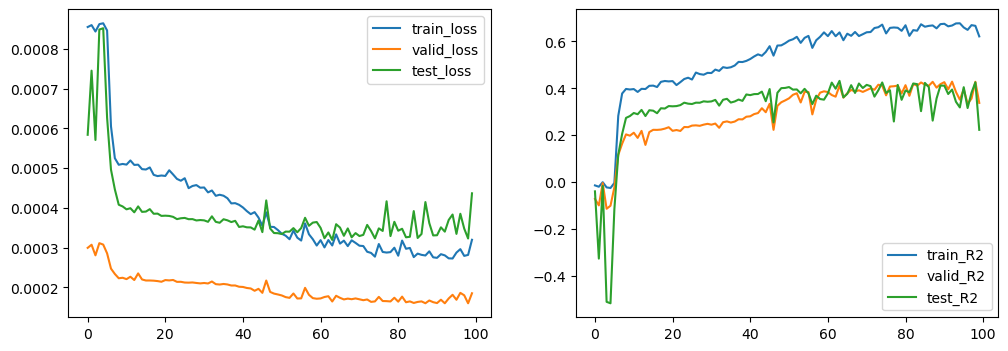

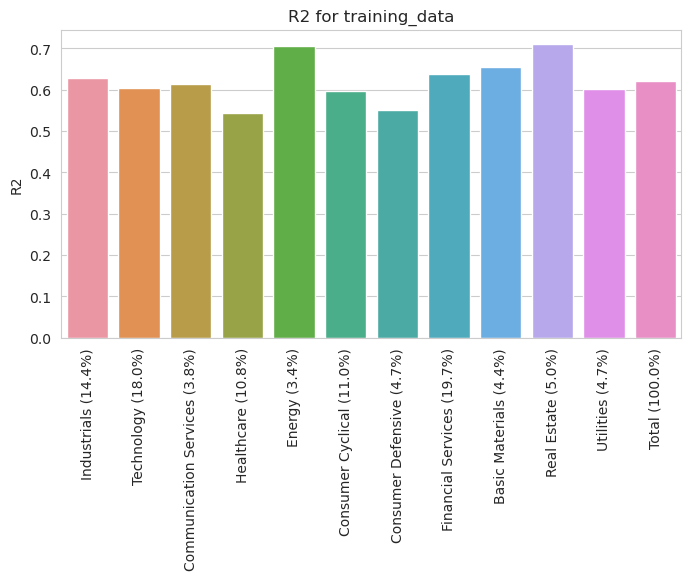

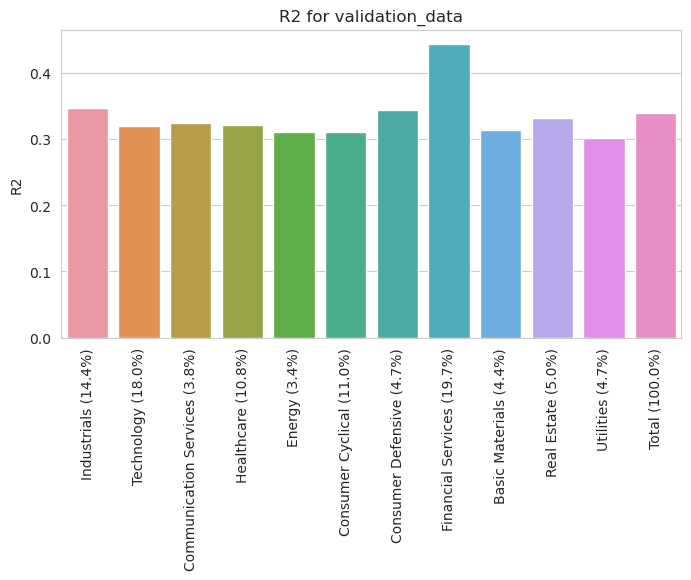

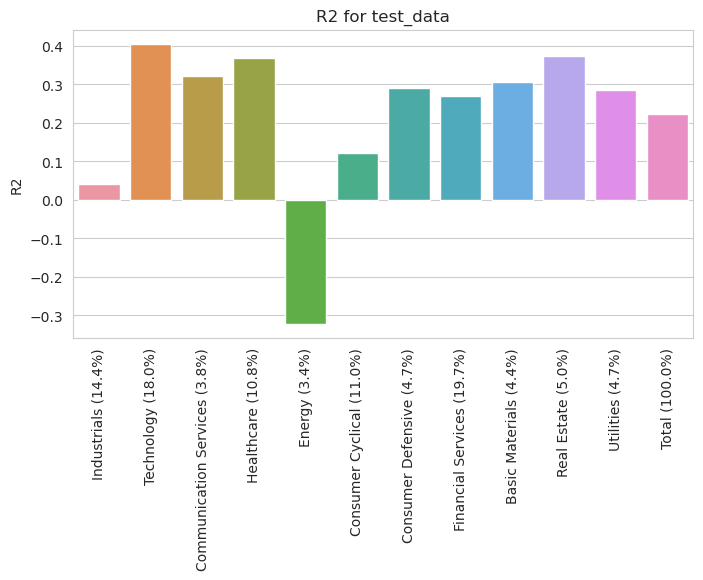

In [20]:
# ---------------- Run Extended model

dataloader_adv={
        'train' : train_dataloader_adv,
        'validation' : validation_dataloader_adv,
        'test' : test_dataloader_adv 
    }

dataset={
    'train' : training_data_adv,
    'validation' : validation_data_adv,
    'test' : test_data_adv
}


T_bkwd=10


# Model parameters

feature_vec_cr_dim=no_beta_factors
feature_vec_LSTM_dim=2*no_beta_factors+2
feature_vec_FF_dim=2*no_beta_factors+1+4

no_conv_layers=2
channel_out=81
kernel_size=2
seq_lgth=T_bkwd-1

cr_aggr_no_layers=5
cr_aggr_no_nodes=100
cr_output_vec_dim=10

LSTM_hidden_layer_dim=10
LSTM_no_layers=5
LSTM_no_nodes=100
LSTM_output_vec_dim=10

num_layers_FF=5
num_hidden_nodes_FF=200
P_dropout=0.2

epochs_E2=100

fname='run_extended'
dataloader=dataloader_adv
model_info="Model: EM2\n\n"
lr=5e-4
weight_decay=1e-9

run_E2_E2(T_bkwd,\
          feature_vec_cr_dim,\
          feature_vec_LSTM_dim,\
          feature_vec_FF_dim,\
          no_conv_layers,\
          channel_out,\
          kernel_size,\
          cr_aggr_no_layers,\
          cr_aggr_no_nodes,\
          cr_output_vec_dim,\
          LSTM_hidden_layer_dim,\
          LSTM_no_layers,\
          LSTM_no_nodes,\
          LSTM_output_vec_dim,\
          num_layers_FF,\
          num_hidden_nodes_FF,\
          P_dropout,\
          epochs_E2,\
          fname,\
          dataloader,\
          dataset,\
          model_info,\
          lr,\
          weight_decay)

## _Extended_ model CRF: Input $(\alpha ,\beta, \Delta F, F)$

This extended model takes all input data first to the convolutional layer block and then to the recurrent layer block and finally to the aggregator. 

In [21]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
#    if torch.backends.mps.is_available()
#    else "cpu"
)
print(f"Using {device} device")

# Define CRF model


class NN_CRF(nn.Module):
    def __init__(self,feature_vec_dim_cr,add_feature_vec_dim_FF,output_vec_dim,\
                 no_conv_layers,channel_out,kernel_size,seq_lgth,\
                 LSTM_hidden_layer_dim,aggr_num_layers,aggr_num_nodes,aggr_output_vec_dim,\
                 num_layers_FF,num_hidden_nodes_FF,P_dropout,activation=None,batch_first=True):

        super().__init__()

        # Set data

        self.feature_vec_dim=feature_vec_dim_cr
        self.add_feature_vec_dim_FF=add_feature_vec_dim_FF
        self.seq_lgth=seq_lgth

        if activation==None:

            self.activation=nn.ReLU()
            
        else:
            
            self.activation=activation
            
        # Convolution layer
            
        if no_conv_layers>0: 

            channel_out_lst=[]
            kernel_size_lst=[]
            for ii in range(no_conv_layers):
                channel_out_lst.append(channel_out)
                kernel_size_lst.append(kernel_size)

            layer_lst,C_out,L_out=gen_Conv1D_block(feature_vec_dim_cr,no_conv_layers,channel_out_lst,kernel_size_lst,seq_lgth)

            self.conv=nn.Sequential(*layer_lst)

            conv_dim_out=C_out
    
            conv_lgth=L_out
            
            self.flag_conv=True 
            
        else:
            
            conv_dim_out=feature_vec_dim_cr
            
            conv_lgth=self.seq_lgth
            
            self.flag_conv=False
            
        
        # LSTM layer
        
        if LSTM_hidden_layer_dim>0 and conv_dim_out>0: 
        

            LSTM_input_dim=conv_dim_out

            self.LSTM=nn.LSTM(input_size=LSTM_input_dim,hidden_size=LSTM_hidden_layer_dim,\
                    batch_first=batch_first) # LSTM x_t=(alpha,beta,d_factor,return)
            
            LSTM_output_dim=LSTM_hidden_layer_dim*conv_lgth
            
            self.flag_LSTM=True


        else:
            
            LSTM_output_dim=conv_dim_out*conv_lgth
            
            self.flag_LSTM=False

        
        # Create aggregator block
        
        if LSTM_output_dim>0:
        
            aggr_block=gen_FFN_block(feature_vec_dim=LSTM_output_dim,output_vec_dim=aggr_output_vec_dim,no_hidden_layers=aggr_num_layers,\
                               no_nodes_in_layer=aggr_num_nodes,P_dropout=P_dropout,activation=activation) 
        
                                    
            self.aggr_block=nn.Sequential(*aggr_block) 
            
            self.flag_aggr_layer=True
            
        else:
            aggr_output_vec_dim=0
            
            self.flag_aggr_laye=False 
            

        # FFN layer

        dim_FFN_input=aggr_output_vec_dim+add_feature_vec_dim_FF
            
        FFN=gen_FFN_block(feature_vec_dim=dim_FFN_input,output_vec_dim=output_vec_dim,no_hidden_layers=num_layers_FF,\
                               no_nodes_in_layer=num_hidden_nodes_FF,P_dropout=P_dropout,activation=activation) 
              
        
        self.FFN=nn.Sequential(*FFN)
            
    

    def forward(self, x):

        x_cr=x[:,:self.seq_lgth,:]
        x_model_t=x[:,self.seq_lgth,:self.add_feature_vec_dim_FF]
             
        
        if self.flag_conv: 
            
            x_cr=torch.permute(x_cr,(0,2,1)) 
                    
            x_cr=self.conv(x_cr)
            
            x_cr=torch.permute(x_cr,(0,2,1))             
        
        
        if self.flag_LSTM: 
                    
            x_LSTM,param=self.LSTM(x_cr)    
            
        else:
            
            x_LSTM=x_cr
            
        x_LSTM=torch.flatten(x_LSTM,start_dim=1)               
                        
            
        if self.flag_aggr_layer:
        
            x_LSTM=self.aggr_block(x_LSTM)
            
        
                                        
        x=torch.cat((x_LSTM,x_model_t),dim=1)
        
        return_vec=self.FFN(x)
                
        return return_vec


Using cuda device


Run the CRF model where the number of factors is 9:

In [22]:

def run_CRF(T_bkwd,\
        feature_vec_dim_cr,\
        add_feature_vec_dim_FF,\
        output_vec_dim,\
        no_conv_layers,\
        channel_out,\
        kernel_size,\
        LSTM_hidden_layer_dim,\
        aggr_num_layers,\
        aggr_num_nodes,\
        aggr_output_vec_dim,\
        num_layers_FF,\
        num_hidden_nodes_FF,\
        P_dropout,\
        dataloader_E2,
        data_set,\
        epochs_E2,\
        fname,\
        model_info="",\
        lr=5e-4,\
        weight_decay=1e-9):
    
    # -----  Model specification

    seq_lgth=T_bkwd-1

    # Model initialisation 

    model_CRF_E2=NN_CRF(feature_vec_dim_cr,add_feature_vec_dim_FF,output_vec_dim,\
                 no_conv_layers,channel_out,kernel_size,seq_lgth,\
                 LSTM_hidden_layer_dim,aggr_num_layers,aggr_num_nodes,aggr_output_vec_dim,\
                 num_layers_FF,num_hidden_nodes_FF,P_dropout).to(device)

    print(model_CRF_E2)

    loss_fn_CRF_E2 = nn.MSELoss()
    optimizer_CRF_E2 = torch.optim.Adam(model_CRF_E2.parameters(), lr=lr,weight_decay=weight_decay)

    # Run extended CRF factor model 
    
    run_model(model_CRF_E2,optimizer_CRF_E2,loss_fn_CRF_E2,epochs_E2,dataloader_E2,fname,label=model_info)

    # Calculate R2 on sectors

    from_id,to_id=0,training_set_no_data-1
    c_sec_stat(model_CRF_E2,loss_fn_CRF_E2,data_set['train'],sector_name_fname,from_id,to_id,fname,'training_data')

    from_id,to_id=training_set_no_data,training_set_no_data+validation_set_no_data-1
    c_sec_stat(model_CRF_E2,loss_fn_CRF_E2,data_set['validation'],sector_name_fname,from_id,to_id,fname,'validation_data')

    from_id,to_id=training_set_no_data+validation_set_no_data,training_set_no_data+validation_set_no_data+test_set_no_data-1
    c_sec_stat(model_CRF_E2,loss_fn_CRF_E2,data_set['test'],sector_name_fname,from_id,to_id,fname,'test_data')

NN_CRF(
  (activation): ReLU()
  (conv): Sequential(
    (0): Conv1d(20, 81, kernel_size=(2,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(81, 81, kernel_size=(2,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (LSTM): LSTM(81, 10, batch_first=True)
  (aggr_block): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_sta

test R^2=0.4665188789367676

Epoch 41
-------------------------------
training R^2=0.48441416025161743

validation R^2=0.3232811689376831

test R^2=0.4635576605796814

Epoch 42
-------------------------------
training R^2=0.483816921710968

validation R^2=0.3082059621810913

test R^2=0.4606315493583679

Epoch 43
-------------------------------
training R^2=0.47628092765808105

validation R^2=0.30538517236709595

test R^2=0.4538552165031433

Epoch 44
-------------------------------
training R^2=0.4851055145263672

validation R^2=0.30288487672805786

test R^2=0.46081483364105225

Epoch 45
-------------------------------
training R^2=0.4805298447608948

validation R^2=0.30903559923171997

test R^2=0.45594650506973267

Epoch 46
-------------------------------
training R^2=0.4910624027252197

validation R^2=0.31578153371810913

test R^2=0.468997061252594

Epoch 47
-------------------------------
training R^2=0.49430233240127563

validation R^2=0.3263671398162842

test R^2=0.4697218537330627

test R^2=0.4407541751861572

Epoch 100
-------------------------------
training R^2=0.4781303405761719

validation R^2=0.2904566526412964

test R^2=0.44636237621307373

Pareto optimal solution: iter*: 37 training_R2*: 0.495943 validation_R2*: 0.327653 test_R2*: 0.475249


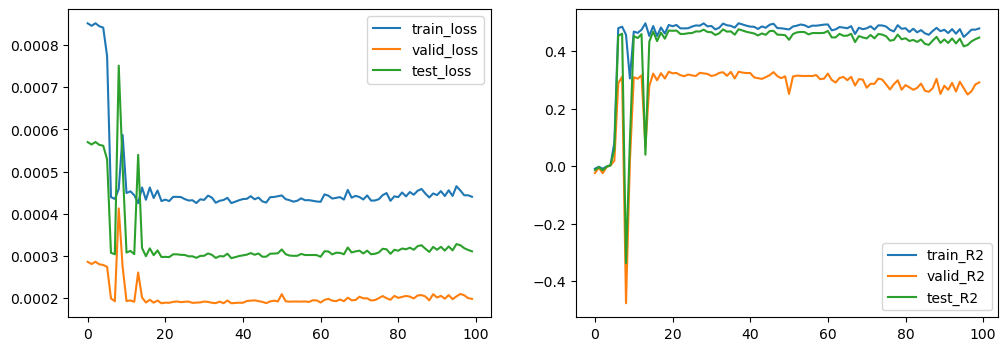

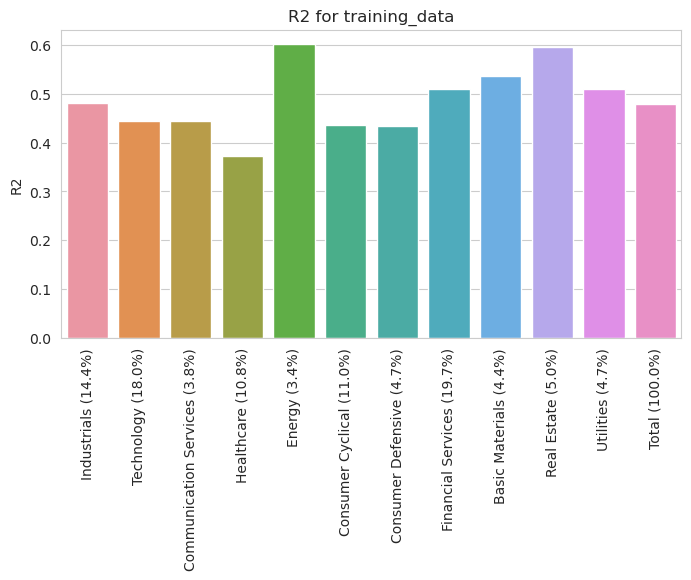

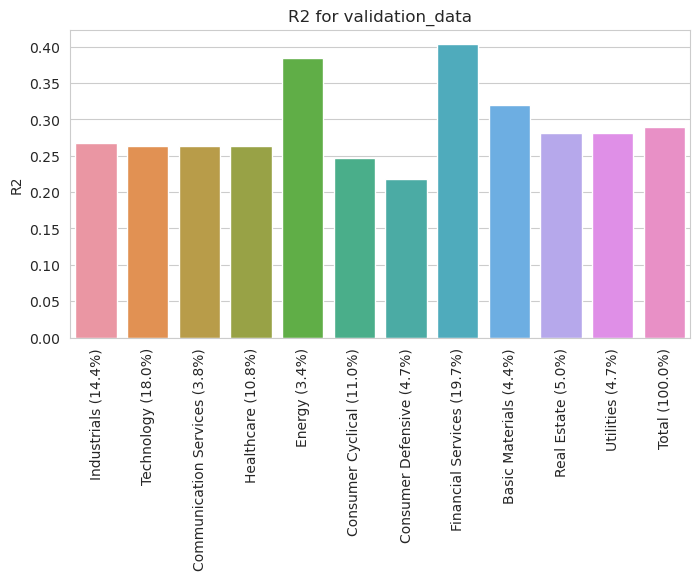

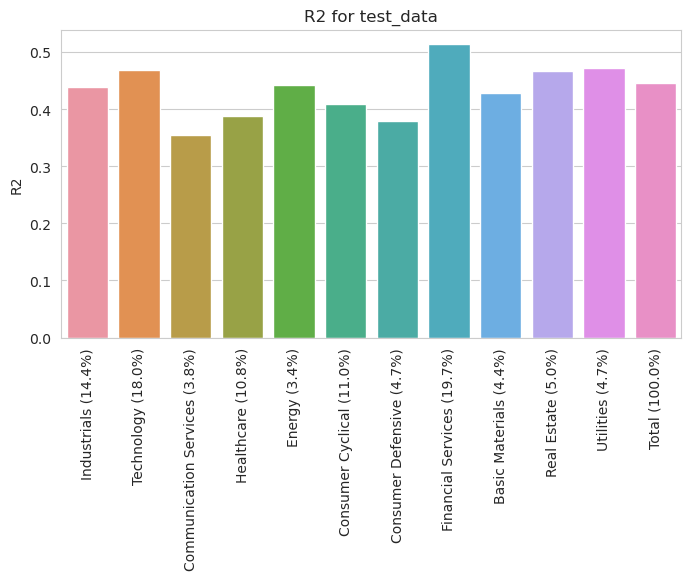

In [23]:
# Run CRF model

dataloader_E2={
    'train' : train_dataloader_E2,
    'validation' : validation_dataloader_E2,
    'test' : test_dataloader_E2 
}

data_set={
    'train' : training_data_E2,
    'validation' : validation_data_E2,
    'test' : test_data_E2
}

run_CRF(T_bkwd=10,\
        feature_vec_dim_cr=2*no_beta_factors+2,\
        add_feature_vec_dim_FF=no_beta_factors+5,\
        output_vec_dim=1,\
        no_conv_layers=2,\
        channel_out=81,\
        kernel_size=2,\
        LSTM_hidden_layer_dim=10,\
        aggr_num_layers=4,\
        aggr_num_nodes=100,\
        aggr_output_vec_dim=10,\
        num_layers_FF=4,\
        num_hidden_nodes_FF=200,\
        P_dropout=0.2,\
        dataloader_E2=dataloader_E2,\
        data_set=data_set,\
        epochs_E2=100,\
        fname='run_CRF',\
        model_info="Model: CRF\n\n",\
        lr=5e-4,\
        weight_decay=1e-9)

# Autoencoder

In [24]:
class AE_data_base(data_base):
    """
    Class that contains data and supports the DataLoader
    """

    def __init__(self,data,from_id=None,to_id=None):
        """ 
        Loads data and store en numpy array
        """


        # ----  Transform data into input and output data

        if from_id==None: 
            from_id=0

        if to_id==None:
            to_id=no_dataset-1

        self.no_data=(to_id-from_id+1)

        dim_feature_vec=(no_beta_factors+no_assets)  # Factor and asset returns

        self.input_data_np=np.zeros((self.no_data,dim_feature_vec),dtype=np.float32)

        self.output_data_np=np.zeros((self.no_data,no_assets),dtype=np.float32)

        p_input_data=0

        for ii in range(from_id,to_id+1):
            self.input_data_np[p_input_data,:]=data.return_data_np[ii,:]
            self.output_data_np[p_input_data,:]=data.return_data_np[ii,no_beta_factors:]
            p_input_data+=1

        self.data=data

        # Transform input and output data into torch tensors

        input_data_t=torch.from_numpy(self.input_data_np)
        output_data_t=torch.from_numpy(self.output_data_np) 

        super().__init__(input_data_t,output_data_t)
        
    def _assign_io_data(self,i_data_t,o_data_t):
        
        self.input_data_t,self.output_data_t=i_data_t,o_data_t

    def filter_data(self,sec_id_lst,from_id,to_id):

        pass
        


# Create data loaders.

training_data_AE=AE_data_base(data,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_AE=AE_data_base(data,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_AE=AE_data_base(data,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

batch_size_AE=50

train_dataloader_AE = DataLoader(training_data_AE,batch_size=batch_size_AE,shuffle=True)
validation_dataloader_AE=DataLoader(validation_data_AE,batch_size=batch_size_AE,shuffle=True)
test_dataloader_AE = DataLoader(test_data_AE,batch_size=batch_size_AE,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_AE.__len__()}')
print(f'number of validation batches {validation_dataloader_AE.__len__()}')
print(f'number of test batches {test_dataloader_AE.__len__()}')

# train_features, train_output = next(iter(train_dataloader_base))
# validation_features, validation_output = next(iter(validation_dataloader_base))
# test_features,test_output=next(iter(test_dataloader_base))


number of training batches 28
number of validation batches 28
number of test batches 28


In [25]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
#    if torch.backends.mps.is_available()
#    else "cpu"
)
print(f"Using {device} device")

# Autoencoder model


class NN_AE(nn.Module):
    def __init__(self,encoder_layer_lst,decoder_layer_lst,P_dropout=0.1,activation=None):

        super().__init__()
        
        FFN=gen_AE_block(encoder_layer_lst,P_dropout,activation)
        
        self.encoder=nn.Sequential(*FFN)
        
        FFN=gen_AE_block(decoder_layer_lst,P_dropout,activation)
        
        self.decoder=nn.Sequential(*FFN)
            
    def forward(self,x):
        
        y=self.encoder(x)
        
        z=self.decoder(y)
        
        return z

Using cuda device


In [26]:
def gen_AE_data(model_AE,data_AE,depr_param=0.005):
    """ generate intrinsic factor returns and (alpha,beta) parameters from the adaptive model"""
    
    x=data_AE.input_data_t.to(device)
    
    ifactor_returns_t=model_AE.encoder(x)
    
    
    x=ifactor_returns_t.to(device="cpu")
    ifactor_returns_np=x.detach().numpy()
    ofactor_returns_np=data_AE.output_data_t.numpy()
    
    (no_data,no_factors)=ifactor_returns_np.shape
    
    start_window=3*no_factors
    
    return_data_np=np.concatenate((ifactor_returns_np,ofactor_returns_np),axis=1)
    
    model=invlib.asset_model()

    factor_weights,prediction_error,stat_param_var,err_var=model.calibrate_adaptive_linear_model(\
                                                                   return_data_np,no_factors,\
                                                                   depr_param=depr_param,init_window=start_window)
    
    # Calculate intrinsic factor levels
    
    ifactor_levels_np=torch.cumsum(data_AE.input_data_t[:,:no_factors],dim=1).numpy()
    
    return return_data_np,factor_weights,prediction_error, ifactor_levels_np
        


Run the autoencoder where the intrinsic dimensioin is 20:

In [27]:
# ******************** Flag that controls if new data related to AE factors are generated

flag_generate_AE_factor_info=False # If true data new AE factor related data are generated

# *********************


# -----  Model specification AE

def run_AE():

    # Model parameters
    
    no_intrinsic_factors=20

    encoder_layer_lst=[no_beta_factors+no_assets,no_intrinsic_factors]
    decoder_layer_lst=[no_intrinsic_factors,no_assets]
    
    P_dropout=0.1

    # Model initialisation 

#    model_AE=NN_AE(encoder_layer_lst,decoder_layer_lst,P_dropout,activation=nn.ReLU()).to(device)
    model_AE=NN_AE(encoder_layer_lst,decoder_layer_lst,P_dropout,activation=None).to(device) # linear activation function

    print(model_AE)

    loss_fn_AE = nn.MSELoss()
    optimizer_AE = torch.optim.Adam(model_AE.parameters(), lr=1e-3,weight_decay=1e-9)

    # Run simple factor model with factor changes and (alpha,beta) as input and output is return

    epochs_AE=1000

    fname='run_AE'


    dataloader_AE={
        'train' : train_dataloader_AE,
        'validation' : validation_dataloader_AE,
        'test' : test_dataloader_AE 
    }

    model_info="Model: AE\n dataset: AE\n run_id: AE\n\n"

    run_model(model_AE,optimizer_AE,loss_fn_AE,epochs_AE,dataloader_AE,fname,label=model_info)
    
    if flag_generate_AE_factor_info: 
    
        # generate intrinsic factors and (alpha,beta) parammeters and error vector and save to files    
    
        depr_param=0.005
    
        ifactor_fn='ifactor_return'
    
        all_data_AE=AE_data_base(data,from_id=0,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1) 
    
        all_data=DataLoader(all_data_AE,batch_size=1,shuffle=False)
    
        ireturn_levels,ifactor_weights,prediction_error,ifactor_levels=gen_AE_data(model_AE,all_data_AE,depr_param)
    
    
        #--- save data
    
        factor_weights_fn='intr_factor_weights'
        prediction_error_fn='intr_pred_error'    
        factor_levels_fn='intr_factor_levels'    
        return_levels_fn='intr_return_levels'
    
        # reshaping factor weights
    
        loader=invlib.asset_data()

        (t_data,n_factors,n_comp)=ifactor_weights.shape
        n_data_fw=t_data*n_factors*n_comp

        loader.save_return_data_to_file(factor_weights_fn,np.reshape(ifactor_weights,n_data_fw))    
        loader.save_return_data_to_file(prediction_error_fn,prediction_error)
        loader.save_return_data_to_file(factor_levels_fn,ifactor_levels)
        loader.save_return_data_to_file(return_levels_fn,ireturn_levels)
    
        # print info
    
        print(f'ifactor_weights {ifactor_weights.shape}')
        print(f'prediction_error {prediction_error.shape}')
        print(f'ireturn_levels {ifactor_levels.shape}')
        print(f'ifactor_returns {ireturn_levels.shape}')


NN_AE(
  (encoder): Sequential(
    (0): Linear(in_features=647, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=638, bias=True)
  )
)
Epoch 1
-------------------------------
training R^2=-10.933305740356445

validation R^2=-33.24271774291992

test R^2=-16.431697845458984

Epoch 2
-------------------------------
training R^2=-2.871255397796631

validation R^2=-8.730818748474121

test R^2=-4.363257884979248

Epoch 3
-------------------------------
training R^2=-0.2802724838256836

validation R^2=-1.0184810161590576

test R^2=-0.48007750511169434

Epoch 4
-------------------------------
training R^2=0.10690420866012573

validation R^2=-0.057486772537231445

test R^2=0.04814565181732178

Epoch 5
-------------------------------
training R^2=0.22710704803466797

validation R^2=0.07698047161102295

test R^2=0.16541379690170288

Epoch 6
-------------------------------
training R^2=0.32647860050201416

validation R^2=0.13648205995559692

te

test R^2=0.4497685432434082

Epoch 60
-------------------------------
training R^2=0.5360466241836548

validation R^2=0.30247974395751953

test R^2=0.44814860820770264

Epoch 61
-------------------------------
training R^2=0.5360827445983887

validation R^2=0.3019750118255615

test R^2=0.4574546813964844

Epoch 62
-------------------------------
training R^2=0.5363882780075073

validation R^2=0.30505073070526123

test R^2=0.4509845972061157

Epoch 63
-------------------------------
training R^2=0.5365432500839233

validation R^2=0.305325984954834

test R^2=0.45058882236480713

Epoch 64
-------------------------------
training R^2=0.5375882983207703

validation R^2=0.3066718578338623

test R^2=0.45738881826400757

Epoch 65
-------------------------------
training R^2=0.5401798486709595

validation R^2=0.3063706159591675

test R^2=0.45307135581970215

Epoch 66
-------------------------------
training R^2=0.5395736694335938

validation R^2=0.30685555934906006

test R^2=0.45752960443496704

test R^2=0.48277175426483154

Epoch 121
-------------------------------
training R^2=0.5563303232192993

validation R^2=0.3248630166053772

test R^2=0.460842490196228

Epoch 122
-------------------------------
training R^2=0.5322871208190918

validation R^2=0.3044689893722534

test R^2=0.4436368942260742

Epoch 123
-------------------------------
training R^2=0.5468074083328247

validation R^2=0.3221389055252075

test R^2=0.46593135595321655

Epoch 124
-------------------------------
training R^2=0.5740662813186646

validation R^2=0.33511942625045776

test R^2=0.47812217473983765

Epoch 125
-------------------------------
training R^2=0.580581784248352

validation R^2=0.33865171670913696

test R^2=0.48191916942596436

Epoch 126
-------------------------------
training R^2=0.5820798873901367

validation R^2=0.34022057056427

test R^2=0.4843801259994507

Epoch 127
-------------------------------
training R^2=0.5835400819778442

validation R^2=0.3404073119163513

test R^2=0.48466008901596

training R^2=0.5996917486190796

validation R^2=0.3511504530906677

test R^2=0.4949970841407776

Epoch 184
-------------------------------
training R^2=0.6000398993492126

validation R^2=0.35112065076828003

test R^2=0.4937952160835266

Epoch 185
-------------------------------
training R^2=0.5988664627075195

validation R^2=0.3525245189666748

test R^2=0.4914032816886902

Epoch 186
-------------------------------
training R^2=0.6009038686752319

validation R^2=0.35211998224258423

test R^2=0.49462735652923584

Epoch 187
-------------------------------
training R^2=0.6012716293334961

validation R^2=0.3526265621185303

test R^2=0.4939841032028198

Epoch 188
-------------------------------
training R^2=0.6004213094711304

validation R^2=0.35418975353240967

test R^2=0.49572962522506714

Epoch 189
-------------------------------
training R^2=0.6015799641609192

validation R^2=0.3510960340499878

test R^2=0.4934486746788025

Epoch 190
-------------------------------
training R^2=0.6002219

training R^2=0.6064639687538147

validation R^2=0.3561076521873474

test R^2=0.49924975633621216

Epoch 247
-------------------------------
training R^2=0.6066683530807495

validation R^2=0.3581279516220093

test R^2=0.5025037527084351

Epoch 248
-------------------------------
training R^2=0.6108678579330444

validation R^2=0.3568054437637329

test R^2=0.4971233010292053

Epoch 249
-------------------------------
training R^2=0.6077656745910645

validation R^2=0.35977017879486084

test R^2=0.49881798028945923

Epoch 250
-------------------------------
training R^2=0.6055712699890137

validation R^2=0.3582528233528137

test R^2=0.4981544017791748

Epoch 251
-------------------------------
training R^2=0.607150673866272

validation R^2=0.3587346076965332

test R^2=0.4977191686630249

Epoch 252
-------------------------------
training R^2=0.6091898083686829

validation R^2=0.35674452781677246

test R^2=0.4989809989929199

Epoch 253
-------------------------------
training R^2=0.609033107

training R^2=0.6119685173034668

validation R^2=0.36113977432250977

test R^2=0.49908965826034546

Epoch 310
-------------------------------
training R^2=0.6101046800613403

validation R^2=0.3600778579711914

test R^2=0.5003548860549927

Epoch 311
-------------------------------
training R^2=0.611894965171814

validation R^2=0.3621799945831299

test R^2=0.4995020031929016

Epoch 312
-------------------------------
training R^2=0.6106269955635071

validation R^2=0.3642916679382324

test R^2=0.49974459409713745

Epoch 313
-------------------------------
training R^2=0.610276460647583

validation R^2=0.36003077030181885

test R^2=0.5009263157844543

Epoch 314
-------------------------------
training R^2=0.6090435981750488

validation R^2=0.36157137155532837

test R^2=0.49952614307403564

Epoch 315
-------------------------------
training R^2=0.6105915307998657

validation R^2=0.3612098693847656

test R^2=0.4999206066131592

Epoch 316
-------------------------------
training R^2=0.61279344

training R^2=0.6136777400970459

validation R^2=0.3608577847480774

test R^2=0.5047366619110107

Epoch 372
-------------------------------
training R^2=0.6112066507339478

validation R^2=0.3608815670013428

test R^2=0.5009756088256836

Epoch 373
-------------------------------
training R^2=0.6116533279418945

validation R^2=0.3604124188423157

test R^2=0.5000369548797607

Epoch 374
-------------------------------
training R^2=0.6115368604660034

validation R^2=0.36243999004364014

test R^2=0.5030574798583984

Epoch 375
-------------------------------
training R^2=0.6107782125473022

validation R^2=0.3602921962738037

test R^2=0.5036970376968384

Epoch 376
-------------------------------
training R^2=0.6123555898666382

validation R^2=0.36311864852905273

test R^2=0.5034537315368652

Epoch 377
-------------------------------
training R^2=0.6135618686676025

validation R^2=0.36055779457092285

test R^2=0.499347984790802

Epoch 378
-------------------------------
training R^2=0.6120295524

training R^2=0.6166471242904663

validation R^2=0.3602710962295532

test R^2=0.49957436323165894

Epoch 435
-------------------------------
training R^2=0.6124520301818848

validation R^2=0.3620832562446594

test R^2=0.49936622381210327

Epoch 436
-------------------------------
training R^2=0.6164977550506592

validation R^2=0.36343300342559814

test R^2=0.5036290884017944

Epoch 437
-------------------------------
training R^2=0.6138310432434082

validation R^2=0.3620757460594177

test R^2=0.5002847909927368

Epoch 438
-------------------------------
training R^2=0.6143935322761536

validation R^2=0.36146408319473267

test R^2=0.5004665851593018

Epoch 439
-------------------------------
training R^2=0.6131531596183777

validation R^2=0.3622465133666992

test R^2=0.5006779432296753

Epoch 440
-------------------------------
training R^2=0.6130203008651733

validation R^2=0.36305755376815796

test R^2=0.5010458827018738

Epoch 441
-------------------------------
training R^2=0.6135044

training R^2=0.6133315563201904

validation R^2=0.36166447401046753

test R^2=0.5004231929779053

Epoch 498
-------------------------------
training R^2=0.6147346496582031

validation R^2=0.3627166152000427

test R^2=0.5004714727401733

Epoch 499
-------------------------------
training R^2=0.6145213842391968

validation R^2=0.3624163866043091

test R^2=0.5022159814834595

Epoch 500
-------------------------------
training R^2=0.6140308380126953

validation R^2=0.36444729566574097

test R^2=0.5003702640533447

Epoch 501
-------------------------------
training R^2=0.6146681308746338

validation R^2=0.3627776503562927

test R^2=0.500687837600708

Epoch 502
-------------------------------
training R^2=0.6138008832931519

validation R^2=0.3651917576789856

test R^2=0.5012189745903015

Epoch 503
-------------------------------
training R^2=0.6150182485580444

validation R^2=0.364115834236145

test R^2=0.5009487867355347

Epoch 504
-------------------------------
training R^2=0.615249752998

training R^2=0.6150864362716675

validation R^2=0.3636130690574646

test R^2=0.5093817114830017

Epoch 560
-------------------------------
training R^2=0.6139276027679443

validation R^2=0.36289840936660767

test R^2=0.49944645166397095

Epoch 561
-------------------------------
training R^2=0.6151753664016724

validation R^2=0.3636820316314697

test R^2=0.5020380020141602

Epoch 562
-------------------------------
training R^2=0.6154022216796875

validation R^2=0.36346954107284546

test R^2=0.502338707447052

Epoch 563
-------------------------------
training R^2=0.6166625022888184

validation R^2=0.3640848398208618

test R^2=0.5013411641120911

Epoch 564
-------------------------------
training R^2=0.6113852262496948

validation R^2=0.3593055009841919

test R^2=0.49714964628219604

Epoch 565
-------------------------------
training R^2=0.6045031547546387

validation R^2=0.35609757900238037

test R^2=0.48995888233184814

Epoch 566
-------------------------------
training R^2=0.6132990

training R^2=0.6152963638305664

validation R^2=0.36430448293685913

test R^2=0.5004682540893555

Epoch 622
-------------------------------
training R^2=0.6152655482292175

validation R^2=0.3629158139228821

test R^2=0.5005228519439697

Epoch 623
-------------------------------
training R^2=0.6179403066635132

validation R^2=0.36629605293273926

test R^2=0.5029498934745789

Epoch 624
-------------------------------
training R^2=0.6160191893577576

validation R^2=0.3630250096321106

test R^2=0.49820423126220703

Epoch 625
-------------------------------
training R^2=0.6188443303108215

validation R^2=0.36353617906570435

test R^2=0.5008311867713928

Epoch 626
-------------------------------
training R^2=0.6177027225494385

validation R^2=0.3638269305229187

test R^2=0.5011203289031982

Epoch 627
-------------------------------
training R^2=0.6185028553009033

validation R^2=0.36410725116729736

test R^2=0.5051558017730713

Epoch 628
-------------------------------
training R^2=0.6156935

training R^2=0.6178950071334839

validation R^2=0.3652195930480957

test R^2=0.5008928775787354

Epoch 685
-------------------------------
training R^2=0.617195725440979

validation R^2=0.36591339111328125

test R^2=0.5032448768615723

Epoch 686
-------------------------------
training R^2=0.6177438497543335

validation R^2=0.364021897315979

test R^2=0.5018098950386047

Epoch 687
-------------------------------
training R^2=0.6168526411056519

validation R^2=0.36540794372558594

test R^2=0.5008859634399414

Epoch 688
-------------------------------
training R^2=0.6162164211273193

validation R^2=0.36588817834854126

test R^2=0.5011550188064575

Epoch 689
-------------------------------
training R^2=0.616120457649231

validation R^2=0.3642100691795349

test R^2=0.5011734366416931

Epoch 690
-------------------------------
training R^2=0.6184647679328918

validation R^2=0.3647952079772949

test R^2=0.5004565715789795

Epoch 691
-------------------------------
training R^2=0.617279291152

training R^2=0.6155760288238525

validation R^2=0.36428141593933105

test R^2=0.5053344964981079

Epoch 748
-------------------------------
training R^2=0.6164838075637817

validation R^2=0.3636167049407959

test R^2=0.5089497566223145

Epoch 749
-------------------------------
training R^2=0.6161975264549255

validation R^2=0.36383551359176636

test R^2=0.5010973811149597

Epoch 750
-------------------------------
training R^2=0.6190426349639893

validation R^2=0.36490708589553833

test R^2=0.5013335943222046

Epoch 751
-------------------------------
training R^2=0.6158820390701294

validation R^2=0.3633250594139099

test R^2=0.5015766620635986

Epoch 752
-------------------------------
training R^2=0.6166112422943115

validation R^2=0.36396151781082153

test R^2=0.5017015933990479

Epoch 753
-------------------------------
training R^2=0.6166456937789917

validation R^2=0.36389267444610596

test R^2=0.5080972909927368

Epoch 754
-------------------------------
training R^2=0.6169392

training R^2=0.6144664287567139

validation R^2=0.36409664154052734

test R^2=0.5066395401954651

Epoch 811
-------------------------------
training R^2=0.6148855686187744

validation R^2=0.3634389638900757

test R^2=0.5006649494171143

Epoch 812
-------------------------------
training R^2=0.6164960861206055

validation R^2=0.3647844195365906

test R^2=0.5017006397247314

Epoch 813
-------------------------------
training R^2=0.615564227104187

validation R^2=0.3641465902328491

test R^2=0.5013795495033264

Epoch 814
-------------------------------
training R^2=0.6157565116882324

validation R^2=0.3666788935661316

test R^2=0.5014081597328186

Epoch 815
-------------------------------
training R^2=0.6190014481544495

validation R^2=0.3642917275428772

test R^2=0.5021556615829468

Epoch 816
-------------------------------
training R^2=0.6159916520118713

validation R^2=0.3635047674179077

test R^2=0.5009733438491821

Epoch 817
-------------------------------
training R^2=0.611971795558

training R^2=0.6123288869857788

validation R^2=0.363594651222229

test R^2=0.49958598613739014

Epoch 872
-------------------------------
training R^2=0.6136754751205444

validation R^2=0.36393630504608154

test R^2=0.49956458806991577

Epoch 873
-------------------------------
training R^2=0.6157386898994446

validation R^2=0.36339813470840454

test R^2=0.5004560947418213

Epoch 874
-------------------------------
training R^2=0.6164184212684631

validation R^2=0.36477380990982056

test R^2=0.5021967887878418

Epoch 875
-------------------------------
training R^2=0.6158936023712158

validation R^2=0.3637670874595642

test R^2=0.4999551773071289

Epoch 876
-------------------------------
training R^2=0.6173068284988403

validation R^2=0.3656708002090454

test R^2=0.5052225589752197

Epoch 877
-------------------------------
training R^2=0.6182270050048828

validation R^2=0.36351269483566284

test R^2=0.5013695359230042

Epoch 878
-------------------------------
training R^2=0.6156758

training R^2=0.6160708665847778

validation R^2=0.36512291431427

test R^2=0.5021567940711975

Epoch 935
-------------------------------
training R^2=0.6146633625030518

validation R^2=0.3626444935798645

test R^2=0.49983060359954834

Epoch 936
-------------------------------
training R^2=0.6178579330444336

validation R^2=0.36271369457244873

test R^2=0.49991732835769653

Epoch 937
-------------------------------
training R^2=0.6175190210342407

validation R^2=0.36242371797561646

test R^2=0.5014623403549194

Epoch 938
-------------------------------
training R^2=0.6184638738632202

validation R^2=0.36415618658065796

test R^2=0.5004510879516602

Epoch 939
-------------------------------
training R^2=0.6173399686813354

validation R^2=0.36417949199676514

test R^2=0.506249189376831

Epoch 940
-------------------------------
training R^2=0.6186668276786804

validation R^2=0.36603981256484985

test R^2=0.5013290643692017

Epoch 941
-------------------------------
training R^2=0.61689507

training R^2=0.6168029308319092

validation R^2=0.36561286449432373

test R^2=0.5033754110336304

Epoch 998
-------------------------------
training R^2=0.6204050779342651

validation R^2=0.3645966649055481

test R^2=0.5021066665649414

Epoch 999
-------------------------------
training R^2=0.6207972764968872

validation R^2=0.36479252576828003

test R^2=0.5011431574821472

Epoch 1000
-------------------------------
training R^2=0.6177071928977966

validation R^2=0.3640744090080261

test R^2=0.5004147887229919

Pareto optimal solution: iter*: 832 training_R2*: 0.617259 validation_R2*: 0.364625 test_R2*: 0.509697


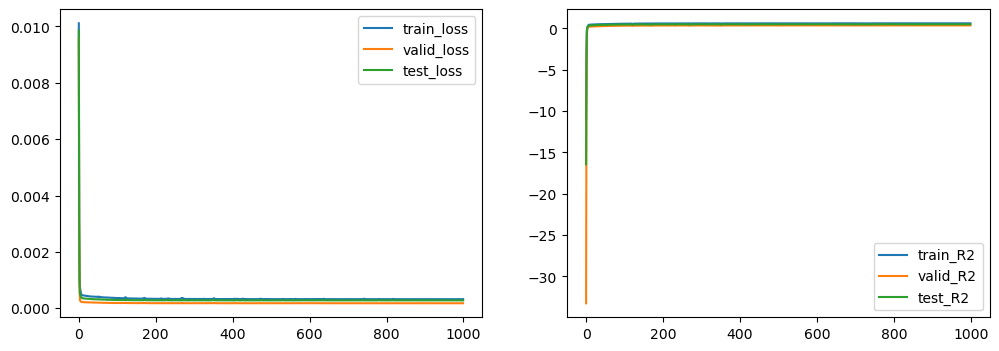

In [28]:
# run AE model

run_AE()

### AE batch run

In [29]:

# -----  Model specification AE

def run_AE_batch(no_intrinsic_factors,encoder_layer_lst,decoder_layer_lst,P_dropout,activation,\
                epochs_AE,fname,lr=1e-3,weight_decay=1e-9):



    # Model initialisation 

    model_AE=NN_AE(encoder_layer_lst,decoder_layer_lst,P_dropout,activation=activation).to(device) 

    print(model_AE)

    loss_fn_AE = nn.MSELoss()
    optimizer_AE = torch.optim.Adam(model_AE.parameters(), lr=lr,weight_decay=weight_decay)

    # Run simple factor model with factor changes and (alpha,beta) as input and output is return


    dataloader_AE={
        'train' : train_dataloader_AE,
        'validation' : validation_dataloader_AE,
        'test' : test_dataloader_AE 
    }

    model_info="Model: AE\n dataset: AE\n run_id: AE\n\n"+'no_intrinsic_factors: '+str(no_intrinsic_factors)+'\n\n'

    run_model(model_AE,optimizer_AE,loss_fn_AE,epochs_AE,dataloader_AE,fname,label=model_info)


In [30]:
# AE batch run

# **********************

flag_run_AE_batch=False

# **********************

if flag_run_AE_batch: 

    encoder_layer_lst=[no_beta_factors+no_assets,3]
    decoder_layer_lst=[3,no_assets]

    run_AE_batch(no_intrinsic_factors=3,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_3',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,7]
    decoder_layer_lst=[7,no_assets]

    run_AE_batch(no_intrinsic_factors=7,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_7',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,11]
    decoder_layer_lst=[11,no_assets]

    run_AE_batch(no_intrinsic_factors=11,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_11',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,15]
    decoder_layer_lst=[15,no_assets]

    run_AE_batch(no_intrinsic_factors=15,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_15',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,20]
    decoder_layer_lst=[20,no_assets]

    run_AE_batch(no_intrinsic_factors=20,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_20',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,30]
    decoder_layer_lst=[30,no_assets]

    run_AE_batch(no_intrinsic_factors=30,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_30',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50]
    decoder_layer_lst=[50,no_assets]

    run_AE_batch(no_intrinsic_factors=50,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_50',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,100]
    decoder_layer_lst=[100,no_assets]

    run_AE_batch(no_intrinsic_factors=100,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_100',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,200]
    decoder_layer_lst=[200,no_assets]

    run_AE_batch(no_intrinsic_factors=200,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_200',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,300]
    decoder_layer_lst=[300,no_assets]

    run_AE_batch(no_intrinsic_factors=300,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_300',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,600]
    decoder_layer_lst=[600,no_assets]

    run_AE_batch(no_intrinsic_factors=600,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=None,epochs_AE=1000,fname='run_AE_600',lr=1e-3,weight_decay=1e-9)



In [31]:
# AE batch runs for non-linear activation

# **********************

flag_run_AE_nl_batch=False

# **********************

if flag_run_AE_nl_batch:

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,3]
    decoder_layer_lst=[3,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=3,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_3',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,7]
    decoder_layer_lst=[7,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=7,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_7',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,11]
    decoder_layer_lst=[11,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=11,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_11',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,15]
    decoder_layer_lst=[15,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=15,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_15',lr=1e-3,weight_decay=1e-9)

    encoder_layer_lst=[no_beta_factors+no_assets,50,25,20]
    decoder_layer_lst=[20,25,50,no_assets]

    run_AE_batch(no_intrinsic_factors=20,encoder_layer_lst=encoder_layer_lst,decoder_layer_lst=decoder_layer_lst,\
    P_dropout=0.1,activation=nn.ReLU(),epochs_AE=1000,fname='run_AE_ln_20',lr=1e-3,weight_decay=1e-9)

# Non-linear Neural network factor models where number of AE factors is 20

In the following the _base_ model and the _extended_ model where 20 AE factors is applied examplified with a configuration that is the most promising.

In [32]:
factor_levels_fname="intr_factor_levels" # File name on factor levels matching factor weights

factor_weights_fname="intr_factor_weights" # File name of factor weights from adaptive model

prediction_error_fname="intr_pred_error" # File name of prediction errors from adaptive model

return_levels_fname="intr_return_levels" # File name for return levels 

ticker_sector_np_fname="ticker_sector_data003" # File name for numpy stucture with sector id

factor_order_fname="factor_order_data.txt" # File with of factor names in adaptive model

asset_order_fname="asset_order_data.txt" # File with asset names in adaptive model

sector_name_fname="sector_id.txt"  # File with sector names

no_beta_factors=20  # Number of beta factors

no_assets=638 # Number of assets

no_dataset=4134  # Number of data

batch_size = 1000  # Batch size

# training_set_no_data=478 # Number of data in training set

# validation_set_no_data=478 # Number of data in validation set

# test_set_no_data=478 # Number of data in test set

training_set_no_data=1378 # Number of data in training set

validation_set_no_data=1378 # Number of data in validation set

test_set_no_data=1378 # Number of data in test set

In [33]:
data_i=database(factor_levels_fname,factor_weights_fname,prediction_error_fname,return_levels_fname,ticker_sector_np_fname)

##  _Base_ model where number of AE factors is 20

In [34]:
# Create data loaders.

training_data_b2_i=market_data_base2(data_i,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_b2_i=market_data_base2(data_i,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_b2_i=market_data_base2(data_i,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_b2_i = DataLoader(training_data_b2_i, batch_size=batch_size,shuffle=True)
validation_dataloader_b2_i=DataLoader(validation_data_b2_i, batch_size=batch_size,shuffle=True)
test_dataloader_b2_i = DataLoader(test_data_b2_i, batch_size=batch_size,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_b2_i.__len__()}')
print(f'number of validation batches {validation_dataloader_b2_i.__len__()}')
print(f'number of test batches {test_dataloader_b2_i.__len__()}')

number of training batches 880
number of validation batches 880
number of test batches 880


NN_B(
  (activation): ReLU()
  (FFN): ModuleList(
    (0): Linear(in_features=21, out_features=50, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=50, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=50, out_features=50, bias=True)
    (17): Dropout(p=0.2, inplace=False)
    (18): BatchNorm1d(50, e

test R^2=0.5947304964065552

Epoch 51
-------------------------------
training R^2=0.6061016321182251

validation R^2=0.45773935317993164

test R^2=0.5924906730651855

Epoch 52
-------------------------------
training R^2=0.571418285369873

validation R^2=0.35200923681259155

test R^2=0.5351822376251221

Epoch 53
-------------------------------
training R^2=0.6125878095626831

validation R^2=0.44584453105926514

test R^2=0.5955660343170166

Epoch 54
-------------------------------
training R^2=0.5578445196151733

validation R^2=0.32962751388549805

test R^2=0.5204746723175049

Epoch 55
-------------------------------
training R^2=0.5625190734863281

validation R^2=0.34406059980392456

test R^2=0.5274873971939087

Epoch 56
-------------------------------
training R^2=0.5674872994422913

validation R^2=0.34885311126708984

test R^2=0.5311245918273926

Epoch 57
-------------------------------
training R^2=0.5401774644851685

validation R^2=0.31112343072891235

test R^2=0.4992474913597107


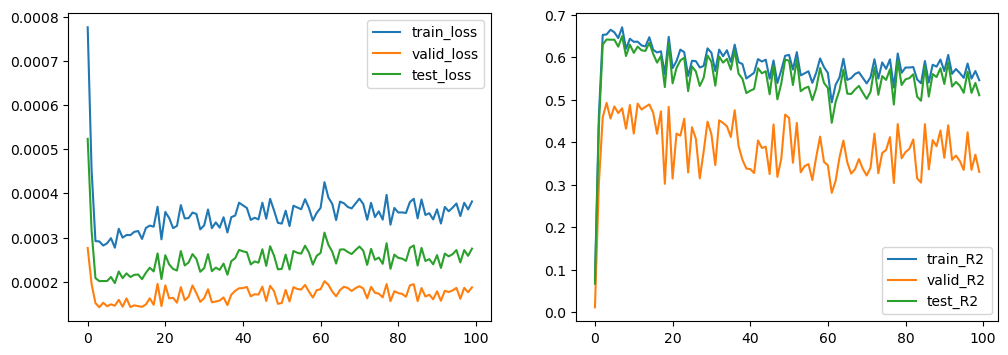

ValueError: operands could not be broadcast together with shapes (1378,9) (1378,20) 

In [35]:
# ------- Run base model


dataset={
        'train' : training_data_b2_i,
        'validation' : validation_data_b2_i,
        'test' : test_data_b2_i 
    }

dataloader_b2={
        'train' : train_dataloader_b2_i,
        'validation' : validation_dataloader_b2_i,
        'test' : test_dataloader_b2_i 
    }

model_info="Model: base model AEfactors=20"


feature_vec_dim_b2=no_beta_factors+1
output_vec_dim=1
num_layers=5
num_hidden_nodes=50
P_dropout=0.2
lr=1e-3
epochs=100
fname='run_base_20'

run_b2(feature_vec_dim_b2,output_vec_dim,num_layers,num_hidden_nodes,P_dropout,lr,epochs,fname,model_info,dataloader_b2,dataset)

##  _Extended_ model where number of AE factors is 20

In [ ]:
batch_size_adv=1000 # Batch size

# Create data loaders.

training_data_adv_i=market_data_adv(data_i,T_bkwd,from_id=0,to_id=training_set_no_data-1)
                          
validation_data_adv_i=market_data_adv(data_i,T_bkwd,from_id=training_set_no_data,to_id=training_set_no_data+validation_set_no_data-1)

test_data_adv_i=market_data_adv(data_i,T_bkwd,from_id=training_set_no_data+validation_set_no_data,to_id=training_set_no_data+validation_set_no_data+test_set_no_data-1)

train_dataloader_adv_i = DataLoader(training_data_adv_i, batch_size=batch_size_adv,shuffle=True)
validation_dataloader_adv_i=DataLoader(validation_data_adv_i, batch_size=batch_size_adv,shuffle=True)
test_dataloader_adv_i = DataLoader(test_data_adv_i, batch_size=batch_size_adv,shuffle=True)

# Test of data loader

print(f'number of training batches {train_dataloader_adv_i.__len__()}')
print(f'number of validation batches {validation_dataloader_adv_i.__len__()}')
print(f'number of test batches {test_dataloader_adv_i.__len__()}')


In [ ]:
# ---------------- Run Extended model for AE factors=20

dataloader_adv={
        'train' : train_dataloader_adv_i,
        'validation' : validation_dataloader_adv_i,
        'test' : test_dataloader_adv_i 
    }

dataset={
    'train' : training_data_adv_i,
    'validation' : validation_data_adv_i,
    'test' : test_data_adv_i
}


T_bkwd=10


# Model parameters

feature_vec_cr_dim=no_beta_factors
feature_vec_LSTM_dim=2*no_beta_factors+2
feature_vec_FF_dim=2*no_beta_factors+1+4

no_conv_layers=2
channel_out=81
kernel_size=2
seq_lgth=T_bkwd-1

cr_aggr_no_layers=5
cr_aggr_no_nodes=100
cr_output_vec_dim=10

LSTM_hidden_layer_dim=10
LSTM_no_layers=5
LSTM_no_nodes=200
LSTM_output_vec_dim=10

num_layers_FF=5
num_hidden_nodes_FF=400
P_dropout=0.2

epochs_E2=100

fname='run_extended_20'
dataloader=dataloader_adv
model_info="Model: EM20\n\n"
lr=5e-4
weight_decay=1e-9

run_E2_E2(T_bkwd,\
          feature_vec_cr_dim,\
          feature_vec_LSTM_dim,\
          feature_vec_FF_dim,\
          no_conv_layers,\
          channel_out,\
          kernel_size,\
          cr_aggr_no_layers,\
          cr_aggr_no_nodes,\
          cr_output_vec_dim,\
          LSTM_hidden_layer_dim,\
          LSTM_no_layers,\
          LSTM_no_nodes,\
          LSTM_output_vec_dim,\
          num_layers_FF,\
          num_hidden_nodes_FF,\
          P_dropout,\
          epochs_E2,\
          fname,\
          dataloader,\
          dataset,\
          model_info,\
          lr,\
          weight_decay)